In [1]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
import stable_baselines3 as sb3
import stable_baselines3.common.logger as logger
import stable_baselines3.common.callbacks as callbacks
import stable_baselines3.common.env_checker as env_checker
from tqdm import tqdm, trange

import flygym.util.vision as vision
from flygym.envs.nmf_mujoco import MuJoCoParameters

import numpy as np
import gymnasium as gym
from typing import Tuple
from dm_control import mjcf
from dm_control.rl.control import PhysicsError

import flygym.util.vision as vision
import flygym.util.config as config
from flygym.arena import BaseArena
from flygym.envs.nmf_mujoco import MuJoCoParameters

from cpg_controller import NMFCPG

/home/sibwang/anaconda3/envs/flygym/lib/python3.8/site-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(
/home/sibwang/anaconda3/envs/flygym/lib/python3.8/site-packages/torch/utils/tensorboard/__init__.py:6: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  ) < LooseVersion("1.15"):


In [2]:
class MovingObjArena(BaseArena):
    """Flat terrain with a hovering moving object.

    Attributes
    ----------
    arena : mjcf.RootElement
        The arena object that the terrain is built on.
    ball_pos : Tuple[float,float,float]
        The position of the floating object in the arena.

    Parameters
    ----------
    size : Tuple[int, int]
        The size of the terrain in (x, y) dimensions.
    friction : Tuple[float, float, float]
        Sliding, torsional, and rolling friction coefficients, by default
        (1, 0.005, 0.0001)
    obj_radius : float
        Radius of the spherical floating object in mm.
    obj_spawn_pos : Tuple[float,float,float]
        Initial position of the object, by default (0, 2, 1).
    move_mode : string
        Type of movement performed by the floating object.
        Can be "random" (default value), "straightHeading", "circling" or "s_shape".
    move_speed : float
        Speed of the moving object. Angular velocity if move_mode=="circling" or "s_shape".
    """

    def __init__(
        self,
        size: Tuple[float, float] = (200, 200),
        friction: Tuple[float, float, float] = (1, 0.005, 0.0001),
        obj_radius: float = 2,
        init_ball_pos: Tuple[float, float, float] = (5, 0),
        move_speed: float = 25,
        move_direction: str = "random",
    ):
        self.init_ball_pos = (*init_ball_pos, obj_radius)
        self.ball_pos = np.array(self.init_ball_pos, dtype="float32")
        self.friction = friction
        self.move_speed = move_speed
        self.curr_time = 0
        self.move_direction = move_direction
        if move_direction == "left":
            self.y_mult = 1
        elif move_direction == "right":
            self.y_mult = -1
        elif move_direction == "random":
            self.y_mult = np.random.choice([-1, 1])
        else:
            raise ValueError("Invalid move_direction")

        self.root_element = mjcf.RootElement()

        # Add ground
        ground_size = [*size, 1]
        chequered = self.root_element.asset.add(
            "texture",
            type="2d",
            builtin="checker",
            width=300,
            height=300,
            rgb1=(0.4, 0.4, 0.4),
            rgb2=(0.5, 0.5, 0.5),
        )
        grid = self.root_element.asset.add(
            "material",
            name="grid",
            texture=chequered,
            texrepeat=(10, 10),
            reflectance=0.1,
        )
        self.root_element.worldbody.add(
            "geom",
            type="plane",
            name="ground",
            material=grid,
            size=ground_size,
            friction=friction,
        )
        self.root_element.worldbody.add("body", name="b_plane")

        # Add ball
        obstacle = self.root_element.asset.add(
            "material", name="obstacle", reflectance=0.1
        )
        self.root_element.worldbody.add(
            "body", name="ball_mocap", mocap=True, pos=self.ball_pos, gravcomp=1
        )
        self.object_body = self.root_element.find("body", "ball_mocap")
        self.object_body.add(
            "geom",
            name="ball",
            type="sphere",
            size=(obj_radius, obj_radius),
            rgba=(0.0, 0.0, 0.0, 1),
            material=obstacle,
        )

        # Add camera
        self.root_element.worldbody.add(
            "camera",
            name="birdseye_cam",
            mode="fixed",
            pos=(0, 0, 50),
            euler=(0, 0, 0),
            fovy=40,
        )

    def get_spawn_position(
        self, rel_pos: np.ndarray, rel_angle: np.ndarray
    ) -> Tuple[np.ndarray, np.ndarray]:
        return rel_pos, rel_angle

    def step(self, dt, physics):
        heading_vec = np.array([1, 0.5 * np.cos(self.curr_time * 3) * self.y_mult])
        heading_vec /= np.linalg.norm(heading_vec)
        self.ball_pos[:2] += self.move_speed * heading_vec * dt
        physics.bind(self.object_body).mocap_pos = self.ball_pos
        self.curr_time += dt

    def reset(self, physics):
        if self.move_direction == "random":
            self.y_mult = np.random.choice([-1, 1])
        self.curr_time = 0
        self.ball_pos = np.array(self.init_ball_pos, dtype="float32")
        physics.bind(self.object_body).mocap_pos = self.ball_pos


class NMFVisualTaxis(NMFCPG):
    def __init__(
        self,
        decision_dt=0.05,
        n_stabilisation_steps: int = 5000,
        obj_threshold=50,
        max_time=2,
        **kwargs
    ) -> None:
        if "sim_params" in kwargs:
            sim_params = kwargs["sim_params"]
            del kwargs["sim_params"]
        else:
            sim_params = MuJoCoParameters()
        sim_params.enable_vision = True
        sim_params.vision_refresh_rate = int(1 / decision_dt)
        self.max_time = max_time

        super().__init__(
            sim_params=sim_params,
            n_oscillators=6,
            n_stabilisation_steps=n_stabilisation_steps,
            **kwargs
        )
        self.decision_dt = decision_dt
        self.obj_threshold = obj_threshold
        self.num_substeps = int(decision_dt / self.timestep)

        # Override spaces
        self.action_space = gym.spaces.Box(low=-1, high=1, shape=(2,))
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=(6,))

        # Compute x-y position of each ommatidium
        self.coms = np.empty((config.num_ommatidia_per_eye, 2))
        for i in range(config.num_ommatidia_per_eye):
            mask = vision.ommatidia_id_map == i + 1
            self.coms[i, :] = np.argwhere(mask).mean(axis=0)

        # self._last_offset_from_ideal = self._calc_offset_from_ideal(
        #     np.zeros(2), self.arena.ball_pos[:2]
        # )
        self._last_fly_tgt_dist = np.linalg.norm(
            np.zeros(2) - (self.arena.ball_pos[:2] - np.array([5, 0]))
        )

    @staticmethod
    def _calc_offset_from_ideal(fly_pos, obj_pos):
        fly_obj_distance = np.linalg.norm(fly_pos - obj_pos)
        return np.abs(fly_obj_distance - 5)

    def step(self, amplitude):
        try:
            for i in range(self.num_substeps):
                raw_obs, _, raw_term, raw_trunc, info = super().step(amplitude)
                super().render()
        except PhysicsError:
            print("Physics error, resetting environment")
            return np.zeros((6,), dtype="float32"), 0, False, True, {}

        assert abs(self.curr_time - self._last_vision_update_time) < 0.5 * self.timestep
        obs = self._get_visual_features().astype("float32")

        # calculate reward
        fly_pos = super().get_observation()["fly"][0, :2]
        obj_pos = self.arena.ball_pos[:2]
        tgt_pos = obj_pos - np.array([5, 0])
        fly_obj_dist = np.linalg.norm(fly_pos - obj_pos)
        fly_tgt_dist = np.linalg.norm(fly_pos - tgt_pos)
        unadjusted_reward = self._last_fly_tgt_dist - fly_tgt_dist
        if obs[2] + obs[5] < 0.005:  # lost object from both eyes, fail
            reward = -15
            terminated = True
            info["state_desc"] = "object lost visually"
        elif fly_tgt_dist > 15:  # too far from object, fail
            reward = -15
            terminated = True
            info["state_desc"] = "too far from object"
        elif fly_obj_dist < 3:  # too close/collision, fail
            reward = -5
            terminated = True
            info["state_desc"] = "collision with object"
        elif fly_tgt_dist < 1:  # ideal range
            reward = 3
            terminated = False
            info["state_desc"] = "ideal range"
        else:
            reward = unadjusted_reward
            terminated = False
            info["state_desc"] = "seeking"
        info["unadjusted_reward"] = unadjusted_reward
        info["fly_obj_dist"] = fly_obj_dist
        info["fly_tgt_dist"] = fly_tgt_dist
        truncated = self.curr_time > 2 and not terminated  # start a new episode
        self._last_fly_tgt_dist = fly_tgt_dist

        return obs, reward, terminated, truncated, info

    def reset(self):
        super().reset()
        self.arena.reset(self.physics)
        obs = self._get_visual_features().astype("float32")
        self._last_fly_tgt_dist = np.linalg.norm(
            np.zeros(2) - (self.arena.ball_pos[:2] - np.array([5, 0]))
        )
        return obs, {}

    def _get_visual_features(self):
        raw_obs = super().get_observation()
        # features = np.full((2, 3), np.nan)  # ({L, R}, {y_center, x_center, area})
        features = np.zeros((2, 3))
        for i, ommatidia_readings in enumerate(raw_obs["vision"]):
            is_obj = ommatidia_readings.max(axis=1) < self.obj_threshold
            is_obj[
                np.arange(is_obj.size) % 2 == 1
            ] = False  # only use pale-type ommatidia
            is_obj_coords = self.coms[is_obj]
            if is_obj_coords.shape[0] > 0:
                features[i, :2] = is_obj_coords.mean(axis=0)
            features[i, 2] = is_obj_coords.shape[0]
        features[:, 0] /= config.raw_img_height_px  # normalize y_center
        features[:, 1] /= config.raw_img_width_px  # normalize x_center
        # features[:, :2] = features[:, :2] * 2 - 1  # center around 0
        features[:, 2] /= config.num_ommatidia_per_eye  # normalize area
        return features.flatten()

In [3]:
np.random.seed(0)
sb3.common.utils.set_random_seed(0, using_cuda=True)

In [4]:
arena = MovingObjArena(init_ball_pos=(5, 0), move_speed=40)
sim_params = MuJoCoParameters(render_playspeed=0.2, render_camera="Animat/camera_top_zoomout", vision_refresh_rate=25)
sim = NMFVisualTaxis(
    sim_params=sim_params,
    arena=arena,
    decision_dt=0.05,
    n_stabilisation_steps=5000,
    obj_threshold=50,
)

obs, info = sim.reset()

for i in range(10):
    obs, reward, terminated, truncated, info = sim.step(np.array([0.5, 0.5]))
    print(reward, terminated, truncated, info)

sim.reset()

obs_hist = [obs]
visual_hist = [sim.curr_visual_input]
ball_pos_hist = []
for i in range(30):
    obs, reward, terminated, truncated, info = sim.step(np.array([0.5, 0.5]))
    obs_hist.append(obs)
    ball_pos_hist.append(sim.arena.ball_pos[:2])
    if i < 9:
        visual_hist.append(sim.curr_visual_input)
    print(reward, terminated, truncated, info)

sim.save_video("visual_taxis_constant_speed_2.mp4")

/home/sibwang/anaconda3/envs/flygym/lib/python3.8/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


-1.160158800825252 False False {'state_desc': 'seeking', 'unadjusted_reward': -1.160158800825252, 'fly_obj_dist': 5.748696756597869, 'fly_tgt_dist': 1.160158800825252}
-0.8244515803580525 False False {'state_desc': 'seeking', 'unadjusted_reward': -0.8244515803580525, 'fly_obj_dist': 5.833879870091854, 'fly_tgt_dist': 1.9846103811833045}
-0.9113643686137052 False False {'state_desc': 'seeking', 'unadjusted_reward': -0.9113643686137052, 'fly_obj_dist': 6.281877737927746, 'fly_tgt_dist': 2.8959747497970096}
-0.858351885288994 False False {'state_desc': 'seeking', 'unadjusted_reward': -0.858351885288994, 'fly_obj_dist': 6.843761873830581, 'fly_tgt_dist': 3.7543266350860036}
-0.7827954829775448 False False {'state_desc': 'seeking', 'unadjusted_reward': -0.7827954829775448, 'fly_obj_dist': 7.452485997999416, 'fly_tgt_dist': 4.537122118063548}
-0.6256272210393377 False False {'state_desc': 'seeking', 'unadjusted_reward': -0.6256272210393377, 'fly_obj_dist': 7.978412974505936, 'fly_tgt_dist': 

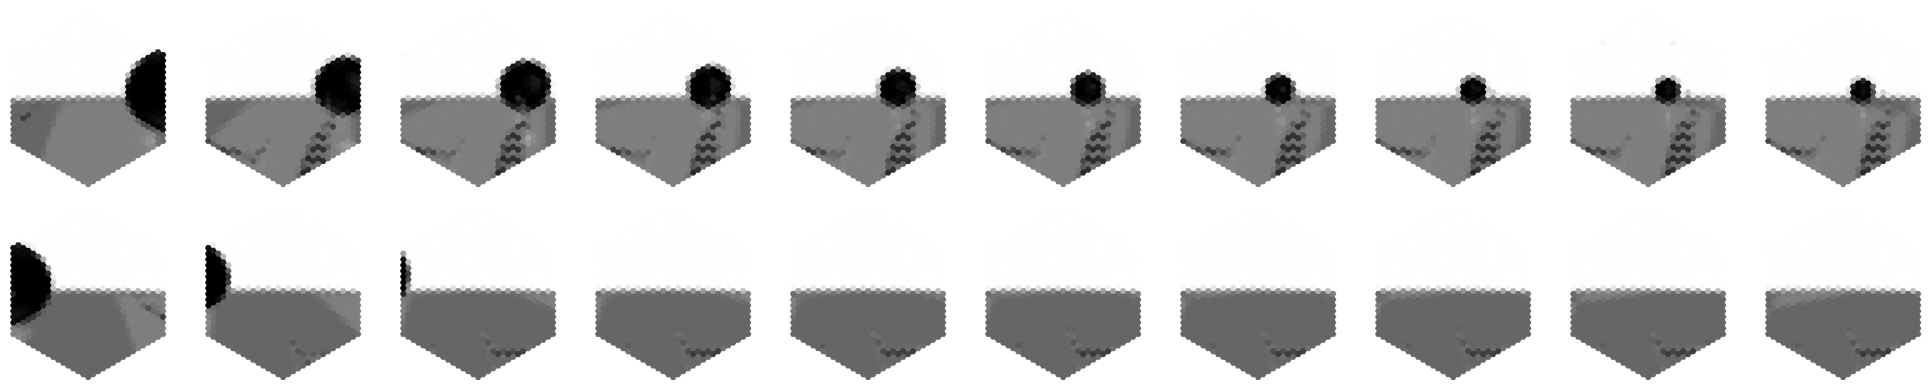

In [5]:
fig, axs = plt.subplots(2, 10, figsize=(20, 4), tight_layout=True)
for i, visual_obs in enumerate(visual_hist):
    human_readable_img_left = vision.hex_pxls_to_human_readable(visual_obs[0], vision.ommatidia_id_map)
    axs[0, i].imshow(human_readable_img_left, cmap="gray", vmin=0, vmax=255)
    axs[0, i].axis("off")
    human_readable_img_right = vision.hex_pxls_to_human_readable(visual_obs[1], vision.ommatidia_id_map)
    axs[1, i].imshow(human_readable_img_right, cmap="gray", vmin=0, vmax=255)
    axs[1, i].axis("off")

(-0.01, 0.3)

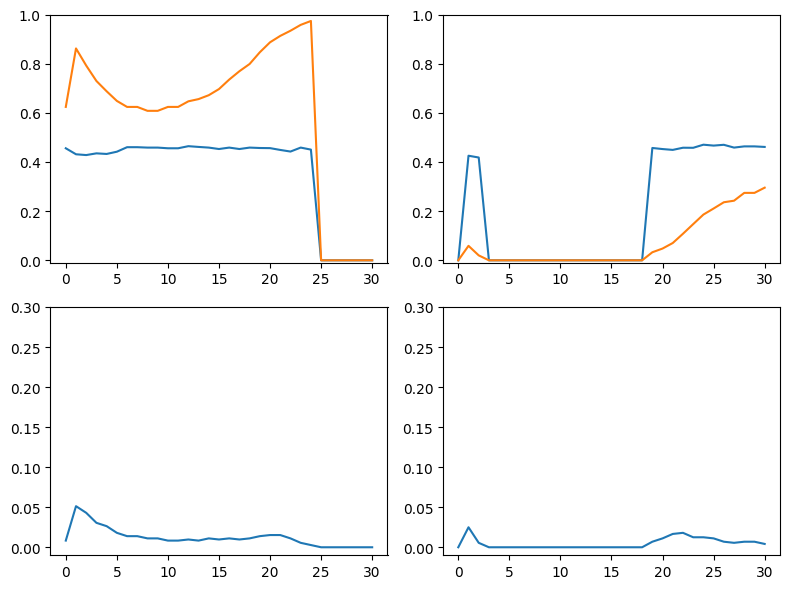

In [6]:
obs_hist = np.array(obs_hist)
fig, axs = plt.subplots(2, 2, figsize=(8, 6), tight_layout=True)
axs[0, 0].plot(obs_hist[:, 0])
axs[0, 0].plot(obs_hist[:, 1])
axs[0, 0].set_ylim(-0.01, 1)
axs[1, 0].plot(obs_hist[:, 2])
axs[1, 0].set_ylim(-0.01, 0.3)

axs[0, 1].plot(obs_hist[:, 3])
axs[0, 1].plot(obs_hist[:, 4])
axs[0, 1].set_ylim(-0.01, 1)
axs[1, 1].plot(obs_hist[:, 5])
axs[1, 1].set_ylim(-0.01, 0.3)

In [7]:
np.random.seed(0)
sb3.common.utils.set_random_seed(0, using_cuda=True)

arena = MovingObjArena(init_ball_pos=(5, 0), move_speed=45)
sim_params = MuJoCoParameters(render_playspeed=0.2, render_camera="Animat/camera_top_zoomout", vision_refresh_rate=25)
task = NMFVisualTaxis(
    sim_params=sim_params,
    arena=arena,
    decision_dt=0.05,
    n_stabilisation_steps=5000,
    obj_threshold=50,
)
env_checker.check_env(task)

start_from = None
train = True

log_dir = "logs/object_tracking_sac_const_speed_2"
checkpoint_callback = callbacks.CheckpointCallback(
  save_freq=1000,
  save_path=log_dir,
  name_prefix="object_tracking_sac_const_speed_2",
  save_replay_buffer=True,
  save_vecnormalize=True,
)
my_logger = logger.configure(log_dir, ["tensorboard", "stdout", "csv"])
model = sb3.SAC("MlpPolicy", env=task, policy_kwargs={"net_arch": [16, 16]}, verbose=2, learning_rate=0.01)
if start_from is not None:
    model = sb3.SAC.load(start_from)
model.set_logger(my_logger)

if train:
    model.learn(total_timesteps=30_000, progress_bar=True, callback=checkpoint_callback)
    model.save("models/object_tracking_sac_const_speed_2")

Logging to logs/object_tracking_sac_const_speed_2
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


Output()

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8        |
|    ep_rew_mean     | -23.9    |
| time/              |          |
|    episodes        | 4        |
|    fps             | 1        |
|    time_elapsed    | 30       |
|    total_timesteps | 32       |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.12     |
|    ep_rew_mean     | -23.7    |
| time/              |          |
|    episodes        | 8        |
|    fps             | 1        |
|    time_elapsed    | 60       |
|    total_timesteps | 65       |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 7.83     |
|    ep_rew_mean     | -23.7    |
| time/              |          |
|    episodes        | 12       |
|    fps             | 1        |
|    time_elapsed    | 87       |
|    total_timesteps | 94       |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 7.75     |
|    ep_rew_mean     | -23.7    |
| time/              |          |
|    episodes        | 16       |
|    fps             | 1        |
|    time_elapsed    | 115      |
|    total_timesteps | 124      |
| train/             |          |
|    actor_loss      | 1.51     |
|    critic_loss     | 18.9     |
|    ent_coef        | 0.802    |
|    ent_coef_loss   | -0.732   |
|    learning_rate   | 0.01     |
|    n_updates       | 23       |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 7.95     |
|    ep_rew_mean     | -23.6    |
| time/              |          |
|    episodes        | 20       |
|    fps             | 1        |
|    time_elapsed    | 147      |
|    total_timesteps | 159      |
| train/             |          |
|    actor_loss      | 1.95     |
|    critic_loss     | 19.6     |
|    ent_coef        | 0.567    |
|    ent_coef_loss   | -1.76    |
|    learning_rate   | 0.01     |
|    n_updates       | 58       |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.67     |
|    ep_rew_mean     | -24      |
| time/              |          |
|    episodes        | 24       |
|    fps             | 1        |
|    time_elapsed    | 190      |
|    total_timesteps | 208      |
| train/             |          |
|    actor_loss      | 2.46     |
|    critic_loss     | 17       |
|    ent_coef        | 0.365    |
|    ent_coef_loss   | -2.52    |
|    learning_rate   | 0.01     |
|    n_updates       | 107      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.79     |
|    ep_rew_mean     | -24      |
| time/              |          |
|    episodes        | 28       |
|    fps             | 1        |
|    time_elapsed    | 224      |
|    total_timesteps | 246      |
| train/             |          |
|    actor_loss      | 2.52     |
|    critic_loss     | 14.4     |
|    ent_coef        | 0.271    |
|    ent_coef_loss   | -2.72    |
|    learning_rate   | 0.01     |
|    n_updates       | 145      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 9.12     |
|    ep_rew_mean     | -24.1    |
| time/              |          |
|    episodes        | 32       |
|    fps             | 1        |
|    time_elapsed    | 266      |
|    total_timesteps | 292      |
| train/             |          |
|    actor_loss      | 3.41     |
|    critic_loss     | 15.5     |
|    ent_coef        | 0.192    |
|    ent_coef_loss   | -3.23    |
|    learning_rate   | 0.01     |
|    n_updates       | 191      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 9.31     |
|    ep_rew_mean     | -24.1    |
| time/              |          |
|    episodes        | 36       |
|    fps             | 1        |
|    time_elapsed    | 305      |
|    total_timesteps | 335      |
| train/             |          |
|    actor_loss      | 3.5      |
|    critic_loss     | 11.1     |
|    ent_coef        | 0.139    |
|    ent_coef_loss   | -3.44    |
|    learning_rate   | 0.01     |
|    n_updates       | 234      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 9.43     |
|    ep_rew_mean     | -24.3    |
| time/              |          |
|    episodes        | 40       |
|    fps             | 1        |
|    time_elapsed    | 344      |
|    total_timesteps | 377      |
| train/             |          |
|    actor_loss      | 4.01     |
|    critic_loss     | 9.98     |
|    ent_coef        | 0.102    |
|    ent_coef_loss   | -5.08    |
|    learning_rate   | 0.01     |
|    n_updates       | 276      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 9.39     |
|    ep_rew_mean     | -24.3    |
| time/              |          |
|    episodes        | 44       |
|    fps             | 1        |
|    time_elapsed    | 378      |
|    total_timesteps | 413      |
| train/             |          |
|    actor_loss      | 4.12     |
|    critic_loss     | 9.96     |
|    ent_coef        | 0.0786   |
|    ent_coef_loss   | -5.31    |
|    learning_rate   | 0.01     |
|    n_updates       | 312      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 9.77     |
|    ep_rew_mean     | -24.5    |
| time/              |          |
|    episodes        | 48       |
|    fps             | 1        |
|    time_elapsed    | 426      |
|    total_timesteps | 469      |
| train/             |          |
|    actor_loss      | 4.7      |
|    critic_loss     | 9.46     |
|    ent_coef        | 0.0547   |
|    ent_coef_loss   | -3.99    |
|    learning_rate   | 0.01     |
|    n_updates       | 368      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 10.2     |
|    ep_rew_mean     | -24.6    |
| time/              |          |
|    episodes        | 52       |
|    fps             | 1        |
|    time_elapsed    | 481      |
|    total_timesteps | 533      |
| train/             |          |
|    actor_loss      | 4.71     |
|    critic_loss     | 6.5      |
|    ent_coef        | 0.0438   |
|    ent_coef_loss   | -1.52    |
|    learning_rate   | 0.01     |
|    n_updates       | 432      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 10.6     |
|    ep_rew_mean     | -24.8    |
| time/              |          |
|    episodes        | 56       |
|    fps             | 1        |
|    time_elapsed    | 532      |
|    total_timesteps | 592      |
| train/             |          |
|    actor_loss      | 5.13     |
|    critic_loss     | 8.53     |
|    ent_coef        | 0.0457   |
|    ent_coef_loss   | 1.48     |
|    learning_rate   | 0.01     |
|    n_updates       | 491      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 10.9     |
|    ep_rew_mean     | -24.9    |
| time/              |          |
|    episodes        | 60       |
|    fps             | 1        |
|    time_elapsed    | 587      |
|    total_timesteps | 656      |
| train/             |          |
|    actor_loss      | 5.4      |
|    critic_loss     | 6.51     |
|    ent_coef        | 0.0508   |
|    ent_coef_loss   | 0.34     |
|    learning_rate   | 0.01     |
|    n_updates       | 555      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 11.1     |
|    ep_rew_mean     | -24.9    |
| time/              |          |
|    episodes        | 64       |
|    fps             | 1        |
|    time_elapsed    | 629      |
|    total_timesteps | 708      |
| train/             |          |
|    actor_loss      | 5.66     |
|    critic_loss     | 7.13     |
|    ent_coef        | 0.0535   |
|    ent_coef_loss   | 0.554    |
|    learning_rate   | 0.01     |
|    n_updates       | 607      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 11.6     |
|    ep_rew_mean     | -25.2    |
| time/              |          |
|    episodes        | 68       |
|    fps             | 1        |
|    time_elapsed    | 699      |
|    total_timesteps | 791      |
| train/             |          |
|    actor_loss      | 6.39     |
|    critic_loss     | 5.29     |
|    ent_coef        | 0.0496   |
|    ent_coef_loss   | -1.66    |
|    learning_rate   | 0.01     |
|    n_updates       | 690      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 11.8     |
|    ep_rew_mean     | -25.3    |
| time/              |          |
|    episodes        | 72       |
|    fps             | 1        |
|    time_elapsed    | 748      |
|    total_timesteps | 850      |
| train/             |          |
|    actor_loss      | 6.76     |
|    critic_loss     | 4.93     |
|    ent_coef        | 0.0429   |
|    ent_coef_loss   | -1.18    |
|    learning_rate   | 0.01     |
|    n_updates       | 749      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 11.9     |
|    ep_rew_mean     | -25.4    |
| time/              |          |
|    episodes        | 76       |
|    fps             | 1        |
|    time_elapsed    | 797      |
|    total_timesteps | 908      |
| train/             |          |
|    actor_loss      | 6.94     |
|    critic_loss     | 5.84     |
|    ent_coef        | 0.0371   |
|    ent_coef_loss   | -1.77    |
|    learning_rate   | 0.01     |
|    n_updates       | 807      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 12.3     |
|    ep_rew_mean     | -25.4    |
| time/              |          |
|    episodes        | 80       |
|    fps             | 1        |
|    time_elapsed    | 860      |
|    total_timesteps | 984      |
| train/             |          |
|    actor_loss      | 7.27     |
|    critic_loss     | 5.11     |
|    ent_coef        | 0.0336   |
|    ent_coef_loss   | 2.92     |
|    learning_rate   | 0.01     |
|    n_updates       | 883      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 12.7     |
|    ep_rew_mean     | -25.4    |
| time/              |          |
|    episodes        | 84       |
|    fps             | 1        |
|    time_elapsed    | 930      |
|    total_timesteps | 1064     |
| train/             |          |
|    actor_loss      | 7.57     |
|    critic_loss     | 4.03     |
|    ent_coef        | 0.0514   |
|    ent_coef_loss   | 2.27     |
|    learning_rate   | 0.01     |
|    n_updates       | 963      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 13.1     |
|    ep_rew_mean     | -25.2    |
| time/              |          |
|    episodes        | 88       |
|    fps             | 1        |
|    time_elapsed    | 1006     |
|    total_timesteps | 1153     |
| train/             |          |
|    actor_loss      | 8.05     |
|    critic_loss     | 2.58     |
|    ent_coef        | 0.0606   |
|    ent_coef_loss   | 0.342    |
|    learning_rate   | 0.01     |
|    n_updates       | 1052     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 13.7     |
|    ep_rew_mean     | -25.2    |
| time/              |          |
|    episodes        | 92       |
|    fps             | 1        |
|    time_elapsed    | 1094     |
|    total_timesteps | 1256     |
| train/             |          |
|    actor_loss      | 8.41     |
|    critic_loss     | 2        |
|    ent_coef        | 0.0746   |
|    ent_coef_loss   | 0.601    |
|    learning_rate   | 0.01     |
|    n_updates       | 1155     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 14.2     |
|    ep_rew_mean     | -24.9    |
| time/              |          |
|    episodes        | 96       |
|    fps             | 1        |
|    time_elapsed    | 1190     |
|    total_timesteps | 1366     |
| train/             |          |
|    actor_loss      | 8.96     |
|    critic_loss     | 1.77     |
|    ent_coef        | 0.0779   |
|    ent_coef_loss   | -0.113   |
|    learning_rate   | 0.01     |
|    n_updates       | 1265     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 14.7     |
|    ep_rew_mean     | -24.6    |
| time/              |          |
|    episodes        | 100      |
|    fps             | 1        |
|    time_elapsed    | 1280     |
|    total_timesteps | 1471     |
| train/             |          |
|    actor_loss      | 9.46     |
|    critic_loss     | 2.23     |
|    ent_coef        | 0.0873   |
|    ent_coef_loss   | -0.132   |
|    learning_rate   | 0.01     |
|    n_updates       | 1370     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 15.7     |
|    ep_rew_mean     | -24.4    |
| time/              |          |
|    episodes        | 104      |
|    fps             | 1        |
|    time_elapsed    | 1386     |
|    total_timesteps | 1599     |
| train/             |          |
|    actor_loss      | 9.8      |
|    critic_loss     | 1.07     |
|    ent_coef        | 0.101    |
|    ent_coef_loss   | -0.665   |
|    learning_rate   | 0.01     |
|    n_updates       | 1498     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 16.3     |
|    ep_rew_mean     | -24.2    |
| time/              |          |
|    episodes        | 108      |
|    fps             | 1        |
|    time_elapsed    | 1471     |
|    total_timesteps | 1696     |
| train/             |          |
|    actor_loss      | 10.1     |
|    critic_loss     | 1.77     |
|    ent_coef        | 0.111    |
|    ent_coef_loss   | 0.845    |
|    learning_rate   | 0.01     |
|    n_updates       | 1595     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.1     |
|    ep_rew_mean     | -24      |
| time/              |          |
|    episodes        | 112      |
|    fps             | 1        |
|    time_elapsed    | 1570     |
|    total_timesteps | 1803     |
| train/             |          |
|    actor_loss      | 10.6     |
|    critic_loss     | 1.18     |
|    ent_coef        | 0.118    |
|    ent_coef_loss   | -0.376   |
|    learning_rate   | 0.01     |
|    n_updates       | 1702     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.5     |
|    ep_rew_mean     | -23.8    |
| time/              |          |
|    episodes        | 116      |
|    fps             | 1        |
|    time_elapsed    | 1629     |
|    total_timesteps | 1872     |
| train/             |          |
|    actor_loss      | 10.8     |
|    critic_loss     | 1.22     |
|    ent_coef        | 0.114    |
|    ent_coef_loss   | 0.523    |
|    learning_rate   | 0.01     |
|    n_updates       | 1771     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.5     |
|    ep_rew_mean     | -23.7    |
| time/              |          |
|    episodes        | 120      |
|    fps             | 1        |
|    time_elapsed    | 1662     |
|    total_timesteps | 1911     |
| train/             |          |
|    actor_loss      | 11       |
|    critic_loss     | 1.6      |
|    ent_coef        | 0.115    |
|    ent_coef_loss   | -0.125   |
|    learning_rate   | 0.01     |
|    n_updates       | 1810     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.8     |
|    ep_rew_mean     | -23.4    |
| time/              |          |
|    episodes        | 124      |
|    fps             | 1        |
|    time_elapsed    | 1723     |
|    total_timesteps | 1983     |
| train/             |          |
|    actor_loss      | 10.7     |
|    critic_loss     | 1.27     |
|    ent_coef        | 0.107    |
|    ent_coef_loss   | 0.278    |
|    learning_rate   | 0.01     |
|    n_updates       | 1882     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.4     |
|    ep_rew_mean     | -23.2    |
| time/              |          |
|    episodes        | 128      |
|    fps             | 1        |
|    time_elapsed    | 1813     |
|    total_timesteps | 2091     |
| train/             |          |
|    actor_loss      | 11.5     |
|    critic_loss     | 0.967    |
|    ent_coef        | 0.0948   |
|    ent_coef_loss   | 0.0104   |
|    learning_rate   | 0.01     |
|    n_updates       | 1990     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19       |
|    ep_rew_mean     | -22.9    |
| time/              |          |
|    episodes        | 132      |
|    fps             | 1        |
|    time_elapsed    | 1901     |
|    total_timesteps | 2191     |
| train/             |          |
|    actor_loss      | 11.7     |
|    critic_loss     | 1.32     |
|    ent_coef        | 0.094    |
|    ent_coef_loss   | 0.103    |
|    learning_rate   | 0.01     |
|    n_updates       | 2090     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.4     |
|    ep_rew_mean     | -22.5    |
| time/              |          |
|    episodes        | 136      |
|    fps             | 1        |
|    time_elapsed    | 1980     |
|    total_timesteps | 2271     |
| train/             |          |
|    actor_loss      | 11.8     |
|    critic_loss     | 1.13     |
|    ent_coef        | 0.0906   |
|    ent_coef_loss   | -0.517   |
|    learning_rate   | 0.01     |
|    n_updates       | 2170     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.7     |
|    ep_rew_mean     | -22.3    |
| time/              |          |
|    episodes        | 140      |
|    fps             | 1        |
|    time_elapsed    | 2060     |
|    total_timesteps | 2350     |
| train/             |          |
|    actor_loss      | 12.1     |
|    critic_loss     | 1.12     |
|    ent_coef        | 0.0924   |
|    ent_coef_loss   | 0.277    |
|    learning_rate   | 0.01     |
|    n_updates       | 2249     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.2     |
|    ep_rew_mean     | -22      |
| time/              |          |
|    episodes        | 144      |
|    fps             | 1        |
|    time_elapsed    | 2145     |
|    total_timesteps | 2434     |
| train/             |          |
|    actor_loss      | 12.3     |
|    critic_loss     | 1.14     |
|    ent_coef        | 0.087    |
|    ent_coef_loss   | 0.0289   |
|    learning_rate   | 0.01     |
|    n_updates       | 2333     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.7     |
|    ep_rew_mean     | -21.6    |
| time/              |          |
|    episodes        | 148      |
|    fps             | 1        |
|    time_elapsed    | 2250     |
|    total_timesteps | 2539     |
| train/             |          |
|    actor_loss      | 12.6     |
|    critic_loss     | 1.24     |
|    ent_coef        | 0.0864   |
|    ent_coef_loss   | 0.161    |
|    learning_rate   | 0.01     |
|    n_updates       | 2438     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.9     |
|    ep_rew_mean     | -21.4    |
| time/              |          |
|    episodes        | 152      |
|    fps             | 1        |
|    time_elapsed    | 2333     |
|    total_timesteps | 2622     |
| train/             |          |
|    actor_loss      | 12.9     |
|    critic_loss     | 1.14     |
|    ent_coef        | 0.079    |
|    ent_coef_loss   | -0.225   |
|    learning_rate   | 0.01     |
|    n_updates       | 2521     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 21.1     |
|    ep_rew_mean     | -21      |
| time/              |          |
|    episodes        | 156      |
|    fps             | 1        |
|    time_elapsed    | 2412     |
|    total_timesteps | 2700     |
| train/             |          |
|    actor_loss      | 13       |
|    critic_loss     | 1.08     |
|    ent_coef        | 0.0758   |
|    ent_coef_loss   | -0.751   |
|    learning_rate   | 0.01     |
|    n_updates       | 2599     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 21.5     |
|    ep_rew_mean     | -20.4    |
| time/              |          |
|    episodes        | 160      |
|    fps             | 1        |
|    time_elapsed    | 2515     |
|    total_timesteps | 2804     |
| train/             |          |
|    actor_loss      | 12.8     |
|    critic_loss     | 1.15     |
|    ent_coef        | 0.0791   |
|    ent_coef_loss   | -0.257   |
|    learning_rate   | 0.01     |
|    n_updates       | 2703     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 21.7     |
|    ep_rew_mean     | -20.3    |
| time/              |          |
|    episodes        | 164      |
|    fps             | 1        |
|    time_elapsed    | 2585     |
|    total_timesteps | 2874     |
| train/             |          |
|    actor_loss      | 13.1     |
|    critic_loss     | 1.45     |
|    ent_coef        | 0.0774   |
|    ent_coef_loss   | -0.0918  |
|    learning_rate   | 0.01     |
|    n_updates       | 2773     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 21.8     |
|    ep_rew_mean     | -19.8    |
| time/              |          |
|    episodes        | 168      |
|    fps             | 1        |
|    time_elapsed    | 2683     |
|    total_timesteps | 2972     |
| train/             |          |
|    actor_loss      | 13.2     |
|    critic_loss     | 1.37     |
|    ent_coef        | 0.0712   |
|    ent_coef_loss   | -0.664   |
|    learning_rate   | 0.01     |
|    n_updates       | 2871     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 22.1     |
|    ep_rew_mean     | -19.6    |
| time/              |          |
|    episodes        | 172      |
|    fps             | 1        |
|    time_elapsed    | 2769     |
|    total_timesteps | 3058     |
| train/             |          |
|    actor_loss      | 14.1     |
|    critic_loss     | 1.58     |
|    ent_coef        | 0.0657   |
|    ent_coef_loss   | -0.525   |
|    learning_rate   | 0.01     |
|    n_updates       | 2957     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 22.5     |
|    ep_rew_mean     | -19.3    |
| time/              |          |
|    episodes        | 176      |
|    fps             | 1        |
|    time_elapsed    | 2866     |
|    total_timesteps | 3155     |
| train/             |          |
|    actor_loss      | 14.1     |
|    critic_loss     | 1.24     |
|    ent_coef        | 0.0659   |
|    ent_coef_loss   | 0.374    |
|    learning_rate   | 0.01     |
|    n_updates       | 3054     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 22.8     |
|    ep_rew_mean     | -19      |
| time/              |          |
|    episodes        | 180      |
|    fps             | 1        |
|    time_elapsed    | 2972     |
|    total_timesteps | 3261     |
| train/             |          |
|    actor_loss      | 14.1     |
|    critic_loss     | 1.91     |
|    ent_coef        | 0.0633   |
|    ent_coef_loss   | 0.714    |
|    learning_rate   | 0.01     |
|    n_updates       | 3160     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 22.6     |
|    ep_rew_mean     | -18.8    |
| time/              |          |
|    episodes        | 184      |
|    fps             | 1        |
|    time_elapsed    | 3037     |
|    total_timesteps | 3326     |
| train/             |          |
|    actor_loss      | 14.5     |
|    critic_loss     | 1.72     |
|    ent_coef        | 0.0602   |
|    ent_coef_loss   | -0.523   |
|    learning_rate   | 0.01     |
|    n_updates       | 3225     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 22.8     |
|    ep_rew_mean     | -18.5    |
| time/              |          |
|    episodes        | 188      |
|    fps             | 1        |
|    time_elapsed    | 3138     |
|    total_timesteps | 3428     |
| train/             |          |
|    actor_loss      | 14.3     |
|    critic_loss     | 1.42     |
|    ent_coef        | 0.0668   |
|    ent_coef_loss   | 0.32     |
|    learning_rate   | 0.01     |
|    n_updates       | 3327     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 22.7     |
|    ep_rew_mean     | -18.2    |
| time/              |          |
|    episodes        | 192      |
|    fps             | 1        |
|    time_elapsed    | 3239     |
|    total_timesteps | 3529     |
| train/             |          |
|    actor_loss      | 14.6     |
|    critic_loss     | 1.34     |
|    ent_coef        | 0.0651   |
|    ent_coef_loss   | -0.989   |
|    learning_rate   | 0.01     |
|    n_updates       | 3428     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 22.8     |
|    ep_rew_mean     | -17.6    |
| time/              |          |
|    episodes        | 196      |
|    fps             | 1        |
|    time_elapsed    | 3357     |
|    total_timesteps | 3649     |
| train/             |          |
|    actor_loss      | 14.7     |
|    critic_loss     | 1.22     |
|    ent_coef        | 0.0699   |
|    ent_coef_loss   | 0.158    |
|    learning_rate   | 0.01     |
|    n_updates       | 3548     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 23.1     |
|    ep_rew_mean     | -16.9    |
| time/              |          |
|    episodes        | 200      |
|    fps             | 1        |
|    time_elapsed    | 3486     |
|    total_timesteps | 3779     |
| train/             |          |
|    actor_loss      | 14.6     |
|    critic_loss     | 1.57     |
|    ent_coef        | 0.0655   |
|    ent_coef_loss   | -0.059   |
|    learning_rate   | 0.01     |
|    n_updates       | 3678     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 22.4     |
|    ep_rew_mean     | -17.2    |
| time/              |          |
|    episodes        | 204      |
|    fps             | 1        |
|    time_elapsed    | 3546     |
|    total_timesteps | 3840     |
| train/             |          |
|    actor_loss      | 15       |
|    critic_loss     | 1.55     |
|    ent_coef        | 0.072    |
|    ent_coef_loss   | -0.353   |
|    learning_rate   | 0.01     |
|    n_updates       | 3739     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 22.5     |
|    ep_rew_mean     | -17      |
| time/              |          |
|    episodes        | 208      |
|    fps             | 1        |
|    time_elapsed    | 3656     |
|    total_timesteps | 3950     |
| train/             |          |
|    actor_loss      | 14.8     |
|    critic_loss     | 1.5      |
|    ent_coef        | 0.0722   |
|    ent_coef_loss   | 0.13     |
|    learning_rate   | 0.01     |
|    n_updates       | 3849     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 22.6     |
|    ep_rew_mean     | -17      |
| time/              |          |
|    episodes        | 212      |
|    fps             | 1        |
|    time_elapsed    | 3770     |
|    total_timesteps | 4066     |
| train/             |          |
|    actor_loss      | 15.4     |
|    critic_loss     | 1.65     |
|    ent_coef        | 0.0739   |
|    ent_coef_loss   | -1.76    |
|    learning_rate   | 0.01     |
|    n_updates       | 3965     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 23.1     |
|    ep_rew_mean     | -15.8    |
| time/              |          |
|    episodes        | 216      |
|    fps             | 1        |
|    time_elapsed    | 3880     |
|    total_timesteps | 4178     |
| train/             |          |
|    actor_loss      | 15.6     |
|    critic_loss     | 1.93     |
|    ent_coef        | 0.0656   |
|    ent_coef_loss   | 0.855    |
|    learning_rate   | 0.01     |
|    n_updates       | 4077     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 24       |
|    ep_rew_mean     | -15      |
| time/              |          |
|    episodes        | 220      |
|    fps             | 1        |
|    time_elapsed    | 4010     |
|    total_timesteps | 4309     |
| train/             |          |
|    actor_loss      | 15.2     |
|    critic_loss     | 1.71     |
|    ent_coef        | 0.0692   |
|    ent_coef_loss   | -0.0883  |
|    learning_rate   | 0.01     |
|    n_updates       | 4208     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 24.2     |
|    ep_rew_mean     | -14.9    |
| time/              |          |
|    episodes        | 224      |
|    fps             | 1        |
|    time_elapsed    | 4107     |
|    total_timesteps | 4407     |
| train/             |          |
|    actor_loss      | 15.2     |
|    critic_loss     | 2.05     |
|    ent_coef        | 0.0699   |
|    ent_coef_loss   | -0.178   |
|    learning_rate   | 0.01     |
|    n_updates       | 4306     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 23.9     |
|    ep_rew_mean     | -14.8    |
| time/              |          |
|    episodes        | 228      |
|    fps             | 1        |
|    time_elapsed    | 4178     |
|    total_timesteps | 4479     |
| train/             |          |
|    actor_loss      | 15.3     |
|    critic_loss     | 2.44     |
|    ent_coef        | 0.0862   |
|    ent_coef_loss   | -0.347   |
|    learning_rate   | 0.01     |
|    n_updates       | 4378     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 24       |
|    ep_rew_mean     | -15      |
| time/              |          |
|    episodes        | 232      |
|    fps             | 1        |
|    time_elapsed    | 4288     |
|    total_timesteps | 4590     |
| train/             |          |
|    actor_loss      | 15.3     |
|    critic_loss     | 1.64     |
|    ent_coef        | 0.0673   |
|    ent_coef_loss   | -0.0857  |
|    learning_rate   | 0.01     |
|    n_updates       | 4489     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 24.2     |
|    ep_rew_mean     | -15      |
| time/              |          |
|    episodes        | 236      |
|    fps             | 1        |
|    time_elapsed    | 4388     |
|    total_timesteps | 4690     |
| train/             |          |
|    actor_loss      | 15.5     |
|    critic_loss     | 1.36     |
|    ent_coef        | 0.0706   |
|    ent_coef_loss   | 0.0616   |
|    learning_rate   | 0.01     |
|    n_updates       | 4589     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 24.3     |
|    ep_rew_mean     | -14.4    |
| time/              |          |
|    episodes        | 240      |
|    fps             | 1        |
|    time_elapsed    | 4478     |
|    total_timesteps | 4781     |
| train/             |          |
|    actor_loss      | 15.8     |
|    critic_loss     | 2        |
|    ent_coef        | 0.069    |
|    ent_coef_loss   | 0.821    |
|    learning_rate   | 0.01     |
|    n_updates       | 4680     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 24.6     |
|    ep_rew_mean     | -13.8    |
| time/              |          |
|    episodes        | 244      |
|    fps             | 1        |
|    time_elapsed    | 4591     |
|    total_timesteps | 4895     |
| train/             |          |
|    actor_loss      | 15.4     |
|    critic_loss     | 1.47     |
|    ent_coef        | 0.0665   |
|    ent_coef_loss   | 0.378    |
|    learning_rate   | 0.01     |
|    n_updates       | 4794     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 24.4     |
|    ep_rew_mean     | -13.8    |
| time/              |          |
|    episodes        | 248      |
|    fps             | 1        |
|    time_elapsed    | 4671     |
|    total_timesteps | 4977     |
| train/             |          |
|    actor_loss      | 15.8     |
|    critic_loss     | 2.25     |
|    ent_coef        | 0.0706   |
|    ent_coef_loss   | 0.146    |
|    learning_rate   | 0.01     |
|    n_updates       | 4876     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 24.3     |
|    ep_rew_mean     | -13.7    |
| time/              |          |
|    episodes        | 252      |
|    fps             | 1        |
|    time_elapsed    | 4743     |
|    total_timesteps | 5050     |
| train/             |          |
|    actor_loss      | 15.7     |
|    critic_loss     | 2.23     |
|    ent_coef        | 0.0654   |
|    ent_coef_loss   | 0.339    |
|    learning_rate   | 0.01     |
|    n_updates       | 4949     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 24.4     |
|    ep_rew_mean     | -13.9    |
| time/              |          |
|    episodes        | 256      |
|    fps             | 1        |
|    time_elapsed    | 4829     |
|    total_timesteps | 5136     |
| train/             |          |
|    actor_loss      | 15.4     |
|    critic_loss     | 2.11     |
|    ent_coef        | 0.065    |
|    ent_coef_loss   | 0.884    |
|    learning_rate   | 0.01     |
|    n_updates       | 5035     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 24.3     |
|    ep_rew_mean     | -14.4    |
| time/              |          |
|    episodes        | 260      |
|    fps             | 1        |
|    time_elapsed    | 4929     |
|    total_timesteps | 5236     |
| train/             |          |
|    actor_loss      | 16       |
|    critic_loss     | 2.12     |
|    ent_coef        | 0.0658   |
|    ent_coef_loss   | -1.17    |
|    learning_rate   | 0.01     |
|    n_updates       | 5135     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 25       |
|    ep_rew_mean     | -13.5    |
| time/              |          |
|    episodes        | 264      |
|    fps             | 1        |
|    time_elapsed    | 5061     |
|    total_timesteps | 5370     |
| train/             |          |
|    actor_loss      | 15.7     |
|    critic_loss     | 1.41     |
|    ent_coef        | 0.0674   |
|    ent_coef_loss   | -1.12    |
|    learning_rate   | 0.01     |
|    n_updates       | 5269     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 24.9     |
|    ep_rew_mean     | -13.5    |
| time/              |          |
|    episodes        | 268      |
|    fps             | 1        |
|    time_elapsed    | 5153     |
|    total_timesteps | 5464     |
| train/             |          |
|    actor_loss      | 16.5     |
|    critic_loss     | 1.73     |
|    ent_coef        | 0.0664   |
|    ent_coef_loss   | -0.179   |
|    learning_rate   | 0.01     |
|    n_updates       | 5363     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 24.9     |
|    ep_rew_mean     | -13.3    |
| time/              |          |
|    episodes        | 272      |
|    fps             | 1        |
|    time_elapsed    | 5242     |
|    total_timesteps | 5553     |
| train/             |          |
|    actor_loss      | 16.2     |
|    critic_loss     | 1.59     |
|    ent_coef        | 0.067    |
|    ent_coef_loss   | -0.382   |
|    learning_rate   | 0.01     |
|    n_updates       | 5452     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 24.9     |
|    ep_rew_mean     | -12.7    |
| time/              |          |
|    episodes        | 276      |
|    fps             | 1        |
|    time_elapsed    | 5328     |
|    total_timesteps | 5641     |
| train/             |          |
|    actor_loss      | 16.4     |
|    critic_loss     | 1.93     |
|    ent_coef        | 0.0604   |
|    ent_coef_loss   | 0.679    |
|    learning_rate   | 0.01     |
|    n_updates       | 5540     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 24.5     |
|    ep_rew_mean     | -12.9    |
| time/              |          |
|    episodes        | 280      |
|    fps             | 1        |
|    time_elapsed    | 5395     |
|    total_timesteps | 5708     |
| train/             |          |
|    actor_loss      | 16.1     |
|    critic_loss     | 1.75     |
|    ent_coef        | 0.0539   |
|    ent_coef_loss   | -0.163   |
|    learning_rate   | 0.01     |
|    n_updates       | 5607     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 24.5     |
|    ep_rew_mean     | -12.8    |
| time/              |          |
|    episodes        | 284      |
|    fps             | 1        |
|    time_elapsed    | 5467     |
|    total_timesteps | 5780     |
| train/             |          |
|    actor_loss      | 16.1     |
|    critic_loss     | 2.13     |
|    ent_coef        | 0.0571   |
|    ent_coef_loss   | 0.275    |
|    learning_rate   | 0.01     |
|    n_updates       | 5679     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 24.3     |
|    ep_rew_mean     | -13      |
| time/              |          |
|    episodes        | 288      |
|    fps             | 1        |
|    time_elapsed    | 5545     |
|    total_timesteps | 5859     |
| train/             |          |
|    actor_loss      | 16       |
|    critic_loss     | 2.31     |
|    ent_coef        | 0.0604   |
|    ent_coef_loss   | -0.856   |
|    learning_rate   | 0.01     |
|    n_updates       | 5758     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 24.3     |
|    ep_rew_mean     | -12.4    |
| time/              |          |
|    episodes        | 292      |
|    fps             | 1        |
|    time_elapsed    | 5646     |
|    total_timesteps | 5960     |
| train/             |          |
|    actor_loss      | 16.1     |
|    critic_loss     | 1.96     |
|    ent_coef        | 0.0528   |
|    ent_coef_loss   | 0.292    |
|    learning_rate   | 0.01     |
|    n_updates       | 5859     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 24.3     |
|    ep_rew_mean     | -12.6    |
| time/              |          |
|    episodes        | 296      |
|    fps             | 1        |
|    time_elapsed    | 5765     |
|    total_timesteps | 6080     |
| train/             |          |
|    actor_loss      | 16.8     |
|    critic_loss     | 2.26     |
|    ent_coef        | 0.0925   |
|    ent_coef_loss   | -1.29    |
|    learning_rate   | 0.01     |
|    n_updates       | 5979     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 23.9     |
|    ep_rew_mean     | -13.2    |
| time/              |          |
|    episodes        | 300      |
|    fps             | 1        |
|    time_elapsed    | 5856     |
|    total_timesteps | 6172     |
| train/             |          |
|    actor_loss      | 16.2     |
|    critic_loss     | 2.35     |
|    ent_coef        | 0.0719   |
|    ent_coef_loss   | -0.237   |
|    learning_rate   | 0.01     |
|    n_updates       | 6071     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 24.1     |
|    ep_rew_mean     | -13.1    |
| time/              |          |
|    episodes        | 304      |
|    fps             | 1        |
|    time_elapsed    | 5934     |
|    total_timesteps | 6249     |
| train/             |          |
|    actor_loss      | 16.4     |
|    critic_loss     | 2.38     |
|    ent_coef        | 0.0621   |
|    ent_coef_loss   | -0.0792  |
|    learning_rate   | 0.01     |
|    n_updates       | 6148     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 24       |
|    ep_rew_mean     | -13.2    |
| time/              |          |
|    episodes        | 308      |
|    fps             | 1        |
|    time_elapsed    | 6032     |
|    total_timesteps | 6348     |
| train/             |          |
|    actor_loss      | 16.5     |
|    critic_loss     | 2.31     |
|    ent_coef        | 0.0643   |
|    ent_coef_loss   | 0.35     |
|    learning_rate   | 0.01     |
|    n_updates       | 6247     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 24       |
|    ep_rew_mean     | -13.1    |
| time/              |          |
|    episodes        | 312      |
|    fps             | 1        |
|    time_elapsed    | 6144     |
|    total_timesteps | 6462     |
| train/             |          |
|    actor_loss      | 16       |
|    critic_loss     | 2.26     |
|    ent_coef        | 0.0674   |
|    ent_coef_loss   | 0.275    |
|    learning_rate   | 0.01     |
|    n_updates       | 6361     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 23.8     |
|    ep_rew_mean     | -14      |
| time/              |          |
|    episodes        | 316      |
|    fps             | 1        |
|    time_elapsed    | 6238     |
|    total_timesteps | 6556     |
| train/             |          |
|    actor_loss      | 16.6     |
|    critic_loss     | 1.93     |
|    ent_coef        | 0.0628   |
|    ent_coef_loss   | 0.0148   |
|    learning_rate   | 0.01     |
|    n_updates       | 6455     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 23.9     |
|    ep_rew_mean     | -14      |
| time/              |          |
|    episodes        | 320      |
|    fps             | 1        |
|    time_elapsed    | 6373     |
|    total_timesteps | 6694     |
| train/             |          |
|    actor_loss      | 16.4     |
|    critic_loss     | 2.12     |
|    ent_coef        | 0.0586   |
|    ent_coef_loss   | -0.854   |
|    learning_rate   | 0.01     |
|    n_updates       | 6593     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 23.6     |
|    ep_rew_mean     | -13.9    |
| time/              |          |
|    episodes        | 324      |
|    fps             | 1        |
|    time_elapsed    | 6449     |
|    total_timesteps | 6770     |
| train/             |          |
|    actor_loss      | 16.3     |
|    critic_loss     | 2.85     |
|    ent_coef        | 0.0685   |
|    ent_coef_loss   | 0.829    |
|    learning_rate   | 0.01     |
|    n_updates       | 6669     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 24       |
|    ep_rew_mean     | -13.8    |
| time/              |          |
|    episodes        | 328      |
|    fps             | 1        |
|    time_elapsed    | 6558     |
|    total_timesteps | 6881     |
| train/             |          |
|    actor_loss      | 16.5     |
|    critic_loss     | 2.8      |
|    ent_coef        | 0.0538   |
|    ent_coef_loss   | -0.0365  |
|    learning_rate   | 0.01     |
|    n_updates       | 6780     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 23.9     |
|    ep_rew_mean     | -13.3    |
| time/              |          |
|    episodes        | 332      |
|    fps             | 1        |
|    time_elapsed    | 6657     |
|    total_timesteps | 6980     |
| train/             |          |
|    actor_loss      | 16.1     |
|    critic_loss     | 2.33     |
|    ent_coef        | 0.0756   |
|    ent_coef_loss   | -0.0337  |
|    learning_rate   | 0.01     |
|    n_updates       | 6879     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 23.9     |
|    ep_rew_mean     | -13.1    |
| time/              |          |
|    episodes        | 336      |
|    fps             | 1        |
|    time_elapsed    | 6761     |
|    total_timesteps | 7085     |
| train/             |          |
|    actor_loss      | 16.3     |
|    critic_loss     | 2.52     |
|    ent_coef        | 0.0643   |
|    ent_coef_loss   | 0.754    |
|    learning_rate   | 0.01     |
|    n_updates       | 6984     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 24.1     |
|    ep_rew_mean     | -13      |
| time/              |          |
|    episodes        | 340      |
|    fps             | 1        |
|    time_elapsed    | 6861     |
|    total_timesteps | 7186     |
| train/             |          |
|    actor_loss      | 16.3     |
|    critic_loss     | 2.77     |
|    ent_coef        | 0.0679   |
|    ent_coef_loss   | 1.06     |
|    learning_rate   | 0.01     |
|    n_updates       | 7085     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 24.2     |
|    ep_rew_mean     | -12.2    |
| time/              |          |
|    episodes        | 344      |
|    fps             | 1        |
|    time_elapsed    | 6992     |
|    total_timesteps | 7318     |
| train/             |          |
|    actor_loss      | 16.3     |
|    critic_loss     | 2.66     |
|    ent_coef        | 0.0631   |
|    ent_coef_loss   | 0.86     |
|    learning_rate   | 0.01     |
|    n_updates       | 7217     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 24.3     |
|    ep_rew_mean     | -12.5    |
| time/              |          |
|    episodes        | 348      |
|    fps             | 1        |
|    time_elapsed    | 7081     |
|    total_timesteps | 7407     |
| train/             |          |
|    actor_loss      | 16.4     |
|    critic_loss     | 2.36     |
|    ent_coef        | 0.0625   |
|    ent_coef_loss   | -0.0589  |
|    learning_rate   | 0.01     |
|    n_updates       | 7306     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 24.8     |
|    ep_rew_mean     | -12.1    |
| time/              |          |
|    episodes        | 352      |
|    fps             | 1        |
|    time_elapsed    | 7202     |
|    total_timesteps | 7529     |
| train/             |          |
|    actor_loss      | 16.3     |
|    critic_loss     | 2.87     |
|    ent_coef        | 0.0757   |
|    ent_coef_loss   | -1.06    |
|    learning_rate   | 0.01     |
|    n_updates       | 7428     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 24.6     |
|    ep_rew_mean     | -11.6    |
| time/              |          |
|    episodes        | 356      |
|    fps             | 1        |
|    time_elapsed    | 7267     |
|    total_timesteps | 7594     |
| train/             |          |
|    actor_loss      | 16.4     |
|    critic_loss     | 2.06     |
|    ent_coef        | 0.0549   |
|    ent_coef_loss   | -0.627   |
|    learning_rate   | 0.01     |
|    n_updates       | 7493     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 24.4     |
|    ep_rew_mean     | -11.1    |
| time/              |          |
|    episodes        | 360      |
|    fps             | 1        |
|    time_elapsed    | 7346     |
|    total_timesteps | 7675     |
| train/             |          |
|    actor_loss      | 16.8     |
|    critic_loss     | 3.09     |
|    ent_coef        | 0.0563   |
|    ent_coef_loss   | 1.2      |
|    learning_rate   | 0.01     |
|    n_updates       | 7574     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 23.9     |
|    ep_rew_mean     | -11.6    |
| time/              |          |
|    episodes        | 364      |
|    fps             | 1        |
|    time_elapsed    | 7428     |
|    total_timesteps | 7758     |
| train/             |          |
|    actor_loss      | 16.6     |
|    critic_loss     | 3.31     |
|    ent_coef        | 0.0655   |
|    ent_coef_loss   | -0.877   |
|    learning_rate   | 0.01     |
|    n_updates       | 7657     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 23.8     |
|    ep_rew_mean     | -11.4    |
| time/              |          |
|    episodes        | 368      |
|    fps             | 1        |
|    time_elapsed    | 7517     |
|    total_timesteps | 7848     |
| train/             |          |
|    actor_loss      | 16.7     |
|    critic_loss     | 3.36     |
|    ent_coef        | 0.0538   |
|    ent_coef_loss   | -0.0109  |
|    learning_rate   | 0.01     |
|    n_updates       | 7747     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 24.1     |
|    ep_rew_mean     | -10.9    |
| time/              |          |
|    episodes        | 372      |
|    fps             | 1        |
|    time_elapsed    | 7632     |
|    total_timesteps | 7964     |
| train/             |          |
|    actor_loss      | 17.3     |
|    critic_loss     | 2.85     |
|    ent_coef        | 0.0668   |
|    ent_coef_loss   | -0.0708  |
|    learning_rate   | 0.01     |
|    n_updates       | 7863     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 24       |
|    ep_rew_mean     | -11.5    |
| time/              |          |
|    episodes        | 376      |
|    fps             | 1        |
|    time_elapsed    | 7710     |
|    total_timesteps | 8043     |
| train/             |          |
|    actor_loss      | 16.8     |
|    critic_loss     | 2.85     |
|    ent_coef        | 0.0647   |
|    ent_coef_loss   | -0.273   |
|    learning_rate   | 0.01     |
|    n_updates       | 7942     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 24.1     |
|    ep_rew_mean     | -11.3    |
| time/              |          |
|    episodes        | 380      |
|    fps             | 1        |
|    time_elapsed    | 7784     |
|    total_timesteps | 8117     |
| train/             |          |
|    actor_loss      | 17.1     |
|    critic_loss     | 3.08     |
|    ent_coef        | 0.0663   |
|    ent_coef_loss   | -0.205   |
|    learning_rate   | 0.01     |
|    n_updates       | 8016     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 24.4     |
|    ep_rew_mean     | -11.1    |
| time/              |          |
|    episodes        | 384      |
|    fps             | 1        |
|    time_elapsed    | 7885     |
|    total_timesteps | 8219     |
| train/             |          |
|    actor_loss      | 17       |
|    critic_loss     | 2.8      |
|    ent_coef        | 0.0594   |
|    ent_coef_loss   | 0.288    |
|    learning_rate   | 0.01     |
|    n_updates       | 8118     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 24.4     |
|    ep_rew_mean     | -10.9    |
| time/              |          |
|    episodes        | 388      |
|    fps             | 1        |
|    time_elapsed    | 7967     |
|    total_timesteps | 8301     |
| train/             |          |
|    actor_loss      | 17       |
|    critic_loss     | 3.65     |
|    ent_coef        | 0.0669   |
|    ent_coef_loss   | -0.468   |
|    learning_rate   | 0.01     |
|    n_updates       | 8200     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 24.3     |
|    ep_rew_mean     | -11      |
| time/              |          |
|    episodes        | 392      |
|    fps             | 1        |
|    time_elapsed    | 8057     |
|    total_timesteps | 8391     |
| train/             |          |
|    actor_loss      | 16.9     |
|    critic_loss     | 3.77     |
|    ent_coef        | 0.0644   |
|    ent_coef_loss   | 0.407    |
|    learning_rate   | 0.01     |
|    n_updates       | 8290     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 24.2     |
|    ep_rew_mean     | -10.7    |
| time/              |          |
|    episodes        | 396      |
|    fps             | 1        |
|    time_elapsed    | 8165     |
|    total_timesteps | 8499     |
| train/             |          |
|    actor_loss      | 16.8     |
|    critic_loss     | 3.01     |
|    ent_coef        | 0.0623   |
|    ent_coef_loss   | -0.762   |
|    learning_rate   | 0.01     |
|    n_updates       | 8398     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 23.9     |
|    ep_rew_mean     | -10.9    |
| time/              |          |
|    episodes        | 400      |
|    fps             | 1        |
|    time_elapsed    | 8230     |
|    total_timesteps | 8564     |
| train/             |          |
|    actor_loss      | 17.3     |
|    critic_loss     | 3.39     |
|    ent_coef        | 0.0659   |
|    ent_coef_loss   | 0.807    |
|    learning_rate   | 0.01     |
|    n_updates       | 8463     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 24.2     |
|    ep_rew_mean     | -9.54    |
| time/              |          |
|    episodes        | 404      |
|    fps             | 1        |
|    time_elapsed    | 8330     |
|    total_timesteps | 8666     |
| train/             |          |
|    actor_loss      | 17.1     |
|    critic_loss     | 2.38     |
|    ent_coef        | 0.0734   |
|    ent_coef_loss   | 0.642    |
|    learning_rate   | 0.01     |
|    n_updates       | 8565     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 24.6     |
|    ep_rew_mean     | -8.46    |
| time/              |          |
|    episodes        | 408      |
|    fps             | 1        |
|    time_elapsed    | 8473     |
|    total_timesteps | 8810     |
| train/             |          |
|    actor_loss      | 16.8     |
|    critic_loss     | 3.21     |
|    ent_coef        | 0.0732   |
|    ent_coef_loss   | 0.64     |
|    learning_rate   | 0.01     |
|    n_updates       | 8709     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 24.4     |
|    ep_rew_mean     | -8.05    |
| time/              |          |
|    episodes        | 412      |
|    fps             | 1        |
|    time_elapsed    | 8564     |
|    total_timesteps | 8901     |
| train/             |          |
|    actor_loss      | 16.4     |
|    critic_loss     | 3.93     |
|    ent_coef        | 0.0752   |
|    ent_coef_loss   | -0.325   |
|    learning_rate   | 0.01     |
|    n_updates       | 8800     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 24.4     |
|    ep_rew_mean     | -7.95    |
| time/              |          |
|    episodes        | 416      |
|    fps             | 1        |
|    time_elapsed    | 8663     |
|    total_timesteps | 9000     |
| train/             |          |
|    actor_loss      | 16.8     |
|    critic_loss     | 3.46     |
|    ent_coef        | 0.0603   |
|    ent_coef_loss   | 0.497    |
|    learning_rate   | 0.01     |
|    n_updates       | 8899     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 23.8     |
|    ep_rew_mean     | -8.71    |
| time/              |          |
|    episodes        | 420      |
|    fps             | 1        |
|    time_elapsed    | 8733     |
|    total_timesteps | 9070     |
| train/             |          |
|    actor_loss      | 16.9     |
|    critic_loss     | 3.73     |
|    ent_coef        | 0.0773   |
|    ent_coef_loss   | 0.36     |
|    learning_rate   | 0.01     |
|    n_updates       | 8969     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 23.5     |
|    ep_rew_mean     | -8.5     |
| time/              |          |
|    episodes        | 424      |
|    fps             | 1        |
|    time_elapsed    | 8782     |
|    total_timesteps | 9120     |
| train/             |          |
|    actor_loss      | 17.2     |
|    critic_loss     | 2.9      |
|    ent_coef        | 0.0792   |
|    ent_coef_loss   | 0.231    |
|    learning_rate   | 0.01     |
|    n_updates       | 9019     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 23.3     |
|    ep_rew_mean     | -8.7     |
| time/              |          |
|    episodes        | 428      |
|    fps             | 1        |
|    time_elapsed    | 8876     |
|    total_timesteps | 9215     |
| train/             |          |
|    actor_loss      | 16.8     |
|    critic_loss     | 2.75     |
|    ent_coef        | 0.0746   |
|    ent_coef_loss   | -0.00349 |
|    learning_rate   | 0.01     |
|    n_updates       | 9114     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 23.4     |
|    ep_rew_mean     | -8.72    |
| time/              |          |
|    episodes        | 432      |
|    fps             | 1        |
|    time_elapsed    | 8984     |
|    total_timesteps | 9323     |
| train/             |          |
|    actor_loss      | 16.7     |
|    critic_loss     | 3.76     |
|    ent_coef        | 0.0672   |
|    ent_coef_loss   | 1.3      |
|    learning_rate   | 0.01     |
|    n_updates       | 9222     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 23.1     |
|    ep_rew_mean     | -8.55    |
| time/              |          |
|    episodes        | 436      |
|    fps             | 1        |
|    time_elapsed    | 9055     |
|    total_timesteps | 9394     |
| train/             |          |
|    actor_loss      | 16.4     |
|    critic_loss     | 3.52     |
|    ent_coef        | 0.0859   |
|    ent_coef_loss   | 0.0143   |
|    learning_rate   | 0.01     |
|    n_updates       | 9293     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 23.1     |
|    ep_rew_mean     | -8.99    |
| time/              |          |
|    episodes        | 440      |
|    fps             | 1        |
|    time_elapsed    | 9154     |
|    total_timesteps | 9494     |
| train/             |          |
|    actor_loss      | 16.8     |
|    critic_loss     | 3.25     |
|    ent_coef        | 0.0795   |
|    ent_coef_loss   | -0.111   |
|    learning_rate   | 0.01     |
|    n_updates       | 9393     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 22.7     |
|    ep_rew_mean     | -10.3    |
| time/              |          |
|    episodes        | 444      |
|    fps             | 1        |
|    time_elapsed    | 9248     |
|    total_timesteps | 9588     |
| train/             |          |
|    actor_loss      | 16.9     |
|    critic_loss     | 2.81     |
|    ent_coef        | 0.0633   |
|    ent_coef_loss   | -0.595   |
|    learning_rate   | 0.01     |
|    n_updates       | 9487     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 22.6     |
|    ep_rew_mean     | -9.73    |
| time/              |          |
|    episodes        | 448      |
|    fps             | 1        |
|    time_elapsed    | 9320     |
|    total_timesteps | 9662     |
| train/             |          |
|    actor_loss      | 16.9     |
|    critic_loss     | 3.43     |
|    ent_coef        | 0.134    |
|    ent_coef_loss   | 1.39     |
|    learning_rate   | 0.01     |
|    n_updates       | 9561     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 21.9     |
|    ep_rew_mean     | -10.1    |
| time/              |          |
|    episodes        | 452      |
|    fps             | 1        |
|    time_elapsed    | 9376     |
|    total_timesteps | 9718     |
| train/             |          |
|    actor_loss      | 17       |
|    critic_loss     | 3.75     |
|    ent_coef        | 0.117    |
|    ent_coef_loss   | -1.4     |
|    learning_rate   | 0.01     |
|    n_updates       | 9617     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 22.3     |
|    ep_rew_mean     | -10      |
| time/              |          |
|    episodes        | 456      |
|    fps             | 1        |
|    time_elapsed    | 9480     |
|    total_timesteps | 9822     |
| train/             |          |
|    actor_loss      | 16.8     |
|    critic_loss     | 3.55     |
|    ent_coef        | 0.0677   |
|    ent_coef_loss   | -0.856   |
|    learning_rate   | 0.01     |
|    n_updates       | 9721     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 22.5     |
|    ep_rew_mean     | -10.3    |
| time/              |          |
|    episodes        | 460      |
|    fps             | 1        |
|    time_elapsed    | 9582     |
|    total_timesteps | 9925     |
| train/             |          |
|    actor_loss      | 17       |
|    critic_loss     | 2.73     |
|    ent_coef        | 0.0721   |
|    ent_coef_loss   | 0.199    |
|    learning_rate   | 0.01     |
|    n_updates       | 9824     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 22.3     |
|    ep_rew_mean     | -10.5    |
| time/              |          |
|    episodes        | 464      |
|    fps             | 1        |
|    time_elapsed    | 9641     |
|    total_timesteps | 9984     |
| train/             |          |
|    actor_loss      | 16.9     |
|    critic_loss     | 3.84     |
|    ent_coef        | 0.0748   |
|    ent_coef_loss   | 1.04     |
|    learning_rate   | 0.01     |
|    n_updates       | 9883     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 22.4     |
|    ep_rew_mean     | -10.5    |
| time/              |          |
|    episodes        | 468      |
|    fps             | 1        |
|    time_elapsed    | 9741     |
|    total_timesteps | 10085    |
| train/             |          |
|    actor_loss      | 16.6     |
|    critic_loss     | 3.54     |
|    ent_coef        | 0.0634   |
|    ent_coef_loss   | -0.0219  |
|    learning_rate   | 0.01     |
|    n_updates       | 9984     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 22.2     |
|    ep_rew_mean     | -10.9    |
| time/              |          |
|    episodes        | 472      |
|    fps             | 1        |
|    time_elapsed    | 9835     |
|    total_timesteps | 10180    |
| train/             |          |
|    actor_loss      | 17.1     |
|    critic_loss     | 3.85     |
|    ent_coef        | 0.0768   |
|    ent_coef_loss   | -0.316   |
|    learning_rate   | 0.01     |
|    n_updates       | 10079    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 22.5     |
|    ep_rew_mean     | -10.4    |
| time/              |          |
|    episodes        | 476      |
|    fps             | 1        |
|    time_elapsed    | 9947     |
|    total_timesteps | 10293    |
| train/             |          |
|    actor_loss      | 16.8     |
|    critic_loss     | 3.75     |
|    ent_coef        | 0.0745   |
|    ent_coef_loss   | -0.279   |
|    learning_rate   | 0.01     |
|    n_updates       | 10192    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 22.6     |
|    ep_rew_mean     | -10.2    |
| time/              |          |
|    episodes        | 480      |
|    fps             | 1        |
|    time_elapsed    | 10028    |
|    total_timesteps | 10375    |
| train/             |          |
|    actor_loss      | 16.3     |
|    critic_loss     | 3.4      |
|    ent_coef        | 0.0735   |
|    ent_coef_loss   | -0.0414  |
|    learning_rate   | 0.01     |
|    n_updates       | 10274    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 22.6     |
|    ep_rew_mean     | -9.73    |
| time/              |          |
|    episodes        | 484      |
|    fps             | 1        |
|    time_elapsed    | 10129    |
|    total_timesteps | 10477    |
| train/             |          |
|    actor_loss      | 16.9     |
|    critic_loss     | 3.35     |
|    ent_coef        | 0.0612   |
|    ent_coef_loss   | -0.301   |
|    learning_rate   | 0.01     |
|    n_updates       | 10376    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 22.6     |
|    ep_rew_mean     | -10      |
| time/              |          |
|    episodes        | 488      |
|    fps             | 1        |
|    time_elapsed    | 10218    |
|    total_timesteps | 10566    |
| train/             |          |
|    actor_loss      | 16.2     |
|    critic_loss     | 4.01     |
|    ent_coef        | 0.0647   |
|    ent_coef_loss   | 0.277    |
|    learning_rate   | 0.01     |
|    n_updates       | 10465    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 22.5     |
|    ep_rew_mean     | -10.3    |
| time/              |          |
|    episodes        | 492      |
|    fps             | 1        |
|    time_elapsed    | 10294    |
|    total_timesteps | 10642    |
| train/             |          |
|    actor_loss      | 16.3     |
|    critic_loss     | 3.29     |
|    ent_coef        | 0.073    |
|    ent_coef_loss   | 0.328    |
|    learning_rate   | 0.01     |
|    n_updates       | 10541    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 22.6     |
|    ep_rew_mean     | -10.7    |
| time/              |          |
|    episodes        | 496      |
|    fps             | 1        |
|    time_elapsed    | 10407    |
|    total_timesteps | 10755    |
| train/             |          |
|    actor_loss      | 16.9     |
|    critic_loss     | 3.69     |
|    ent_coef        | 0.0805   |
|    ent_coef_loss   | 0.216    |
|    learning_rate   | 0.01     |
|    n_updates       | 10654    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 23.1     |
|    ep_rew_mean     | -10.2    |
| time/              |          |
|    episodes        | 500      |
|    fps             | 1        |
|    time_elapsed    | 10523    |
|    total_timesteps | 10873    |
| train/             |          |
|    actor_loss      | 16.8     |
|    critic_loss     | 3.34     |
|    ent_coef        | 0.0757   |
|    ent_coef_loss   | -0.217   |
|    learning_rate   | 0.01     |
|    n_updates       | 10772    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 23       |
|    ep_rew_mean     | -11.4    |
| time/              |          |
|    episodes        | 504      |
|    fps             | 1        |
|    time_elapsed    | 10616    |
|    total_timesteps | 10966    |
| train/             |          |
|    actor_loss      | 16.6     |
|    critic_loss     | 3.02     |
|    ent_coef        | 0.0723   |
|    ent_coef_loss   | -0.349   |
|    learning_rate   | 0.01     |
|    n_updates       | 10865    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 22.8     |
|    ep_rew_mean     | -12.2    |
| time/              |          |
|    episodes        | 508      |
|    fps             | 1        |
|    time_elapsed    | 10738    |
|    total_timesteps | 11089    |
| train/             |          |
|    actor_loss      | 16.9     |
|    critic_loss     | 3.27     |
|    ent_coef        | 0.0779   |
|    ent_coef_loss   | -0.966   |
|    learning_rate   | 0.01     |
|    n_updates       | 10988    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 22.9     |
|    ep_rew_mean     | -12      |
| time/              |          |
|    episodes        | 512      |
|    fps             | 1        |
|    time_elapsed    | 10844    |
|    total_timesteps | 11196    |
| train/             |          |
|    actor_loss      | 16.8     |
|    critic_loss     | 4.67     |
|    ent_coef        | 0.0688   |
|    ent_coef_loss   | 0.0617   |
|    learning_rate   | 0.01     |
|    n_updates       | 11095    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 22.9     |
|    ep_rew_mean     | -12.2    |
| time/              |          |
|    episodes        | 516      |
|    fps             | 1        |
|    time_elapsed    | 10940    |
|    total_timesteps | 11292    |
| train/             |          |
|    actor_loss      | 16.2     |
|    critic_loss     | 4.05     |
|    ent_coef        | 0.0683   |
|    ent_coef_loss   | 0.0861   |
|    learning_rate   | 0.01     |
|    n_updates       | 11191    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 23.4     |
|    ep_rew_mean     | -11.9    |
| time/              |          |
|    episodes        | 520      |
|    fps             | 1        |
|    time_elapsed    | 11052    |
|    total_timesteps | 11405    |
| train/             |          |
|    actor_loss      | 16.1     |
|    critic_loss     | 3.68     |
|    ent_coef        | 0.0743   |
|    ent_coef_loss   | -0.367   |
|    learning_rate   | 0.01     |
|    n_updates       | 11304    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 23.4     |
|    ep_rew_mean     | -12.3    |
| time/              |          |
|    episodes        | 524      |
|    fps             | 1        |
|    time_elapsed    | 11111    |
|    total_timesteps | 11464    |
| train/             |          |
|    actor_loss      | 16.1     |
|    critic_loss     | 3.18     |
|    ent_coef        | 0.0734   |
|    ent_coef_loss   | -0.328   |
|    learning_rate   | 0.01     |
|    n_updates       | 11363    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 23.2     |
|    ep_rew_mean     | -12.1    |
| time/              |          |
|    episodes        | 528      |
|    fps             | 1        |
|    time_elapsed    | 11180    |
|    total_timesteps | 11534    |
| train/             |          |
|    actor_loss      | 16.6     |
|    critic_loss     | 3.57     |
|    ent_coef        | 0.0641   |
|    ent_coef_loss   | 0.319    |
|    learning_rate   | 0.01     |
|    n_updates       | 11433    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 22.8     |
|    ep_rew_mean     | -12.7    |
| time/              |          |
|    episodes        | 532      |
|    fps             | 1        |
|    time_elapsed    | 11251    |
|    total_timesteps | 11605    |
| train/             |          |
|    actor_loss      | 17       |
|    critic_loss     | 3.07     |
|    ent_coef        | 0.0668   |
|    ent_coef_loss   | 0.105    |
|    learning_rate   | 0.01     |
|    n_updates       | 11504    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 22.8     |
|    ep_rew_mean     | -13.2    |
| time/              |          |
|    episodes        | 536      |
|    fps             | 1        |
|    time_elapsed    | 11317    |
|    total_timesteps | 11672    |
| train/             |          |
|    actor_loss      | 16.8     |
|    critic_loss     | 4.09     |
|    ent_coef        | 0.0677   |
|    ent_coef_loss   | 0.123    |
|    learning_rate   | 0.01     |
|    n_updates       | 11571    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 23       |
|    ep_rew_mean     | -12.9    |
| time/              |          |
|    episodes        | 540      |
|    fps             | 1        |
|    time_elapsed    | 11439    |
|    total_timesteps | 11794    |
| train/             |          |
|    actor_loss      | 16.4     |
|    critic_loss     | 4.67     |
|    ent_coef        | 0.0765   |
|    ent_coef_loss   | 0.0121   |
|    learning_rate   | 0.01     |
|    n_updates       | 11693    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 23       |
|    ep_rew_mean     | -12.4    |
| time/              |          |
|    episodes        | 544      |
|    fps             | 1        |
|    time_elapsed    | 11535    |
|    total_timesteps | 11891    |
| train/             |          |
|    actor_loss      | 16.6     |
|    critic_loss     | 4.22     |
|    ent_coef        | 0.0815   |
|    ent_coef_loss   | -1.17    |
|    learning_rate   | 0.01     |
|    n_updates       | 11790    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 23.7     |
|    ep_rew_mean     | -11.8    |
| time/              |          |
|    episodes        | 548      |
|    fps             | 1        |
|    time_elapsed    | 11679    |
|    total_timesteps | 12036    |
| train/             |          |
|    actor_loss      | 16.3     |
|    critic_loss     | 4.35     |
|    ent_coef        | 0.0743   |
|    ent_coef_loss   | -0.379   |
|    learning_rate   | 0.01     |
|    n_updates       | 11935    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 24.5     |
|    ep_rew_mean     | -10.9    |
| time/              |          |
|    episodes        | 552      |
|    fps             | 1        |
|    time_elapsed    | 11809    |
|    total_timesteps | 12168    |
| train/             |          |
|    actor_loss      | 16.5     |
|    critic_loss     | 3.7      |
|    ent_coef        | 0.0652   |
|    ent_coef_loss   | 0.269    |
|    learning_rate   | 0.01     |
|    n_updates       | 12067    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 24.4     |
|    ep_rew_mean     | -11.1    |
| time/              |          |
|    episodes        | 556      |
|    fps             | 1        |
|    time_elapsed    | 11905    |
|    total_timesteps | 12264    |
| train/             |          |
|    actor_loss      | 16.7     |
|    critic_loss     | 3.16     |
|    ent_coef        | 0.0643   |
|    ent_coef_loss   | 0.663    |
|    learning_rate   | 0.01     |
|    n_updates       | 12163    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 24.5     |
|    ep_rew_mean     | -11.2    |
| time/              |          |
|    episodes        | 560      |
|    fps             | 1        |
|    time_elapsed    | 12017    |
|    total_timesteps | 12378    |
| train/             |          |
|    actor_loss      | 16.3     |
|    critic_loss     | 4.39     |
|    ent_coef        | 0.0654   |
|    ent_coef_loss   | -0.678   |
|    learning_rate   | 0.01     |
|    n_updates       | 12277    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 25.2     |
|    ep_rew_mean     | -10.8    |
| time/              |          |
|    episodes        | 564      |
|    fps             | 1        |
|    time_elapsed    | 12141    |
|    total_timesteps | 12503    |
| train/             |          |
|    actor_loss      | 16.3     |
|    critic_loss     | 4.1      |
|    ent_coef        | 0.0641   |
|    ent_coef_loss   | -0.721   |
|    learning_rate   | 0.01     |
|    n_updates       | 12402    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 24.8     |
|    ep_rew_mean     | -10.8    |
| time/              |          |
|    episodes        | 568      |
|    fps             | 1        |
|    time_elapsed    | 12205    |
|    total_timesteps | 12567    |
| train/             |          |
|    actor_loss      | 16.5     |
|    critic_loss     | 3.72     |
|    ent_coef        | 0.0619   |
|    ent_coef_loss   | 0.46     |
|    learning_rate   | 0.01     |
|    n_updates       | 12466    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 25       |
|    ep_rew_mean     | -10.3    |
| time/              |          |
|    episodes        | 572      |
|    fps             | 1        |
|    time_elapsed    | 12318    |
|    total_timesteps | 12681    |
| train/             |          |
|    actor_loss      | 16.1     |
|    critic_loss     | 3.76     |
|    ent_coef        | 0.06     |
|    ent_coef_loss   | 0.336    |
|    learning_rate   | 0.01     |
|    n_updates       | 12580    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 25.1     |
|    ep_rew_mean     | -9.35    |
| time/              |          |
|    episodes        | 576      |
|    fps             | 1        |
|    time_elapsed    | 12441    |
|    total_timesteps | 12805    |
| train/             |          |
|    actor_loss      | 16.3     |
|    critic_loss     | 2.48     |
|    ent_coef        | 0.0693   |
|    ent_coef_loss   | 0.598    |
|    learning_rate   | 0.01     |
|    n_updates       | 12704    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 25.4     |
|    ep_rew_mean     | -9.02    |
| time/              |          |
|    episodes        | 580      |
|    fps             | 1        |
|    time_elapsed    | 12546    |
|    total_timesteps | 12911    |
| train/             |          |
|    actor_loss      | 16.4     |
|    critic_loss     | 3.5      |
|    ent_coef        | 0.0609   |
|    ent_coef_loss   | 0.249    |
|    learning_rate   | 0.01     |
|    n_updates       | 12810    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 25.8     |
|    ep_rew_mean     | -9.05    |
| time/              |          |
|    episodes        | 584      |
|    fps             | 1        |
|    time_elapsed    | 12695    |
|    total_timesteps | 13061    |
| train/             |          |
|    actor_loss      | 15.5     |
|    critic_loss     | 4.45     |
|    ent_coef        | 0.0701   |
|    ent_coef_loss   | 2.3      |
|    learning_rate   | 0.01     |
|    n_updates       | 12960    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 25.8     |
|    ep_rew_mean     | -8.88    |
| time/              |          |
|    episodes        | 588      |
|    fps             | 1        |
|    time_elapsed    | 12776    |
|    total_timesteps | 13143    |
| train/             |          |
|    actor_loss      | 16.5     |
|    critic_loss     | 3.52     |
|    ent_coef        | 0.0671   |
|    ent_coef_loss   | 0.248    |
|    learning_rate   | 0.01     |
|    n_updates       | 13042    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 26.2     |
|    ep_rew_mean     | -8.4     |
| time/              |          |
|    episodes        | 592      |
|    fps             | 1        |
|    time_elapsed    | 12893    |
|    total_timesteps | 13260    |
| train/             |          |
|    actor_loss      | 15.9     |
|    critic_loss     | 3.89     |
|    ent_coef        | 0.0689   |
|    ent_coef_loss   | 0.149    |
|    learning_rate   | 0.01     |
|    n_updates       | 13159    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 26       |
|    ep_rew_mean     | -8.88    |
| time/              |          |
|    episodes        | 596      |
|    fps             | 1        |
|    time_elapsed    | 12984    |
|    total_timesteps | 13352    |
| train/             |          |
|    actor_loss      | 16.3     |
|    critic_loss     | 3.63     |
|    ent_coef        | 0.0836   |
|    ent_coef_loss   | 0.422    |
|    learning_rate   | 0.01     |
|    n_updates       | 13251    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 26       |
|    ep_rew_mean     | -8.21    |
| time/              |          |
|    episodes        | 600      |
|    fps             | 1        |
|    time_elapsed    | 13107    |
|    total_timesteps | 13475    |
| train/             |          |
|    actor_loss      | 15.4     |
|    critic_loss     | 6        |
|    ent_coef        | 0.0772   |
|    ent_coef_loss   | 0.136    |
|    learning_rate   | 0.01     |
|    n_updates       | 13374    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 25.8     |
|    ep_rew_mean     | -7.49    |
| time/              |          |
|    episodes        | 604      |
|    fps             | 1        |
|    time_elapsed    | 13181    |
|    total_timesteps | 13550    |
| train/             |          |
|    actor_loss      | 15.4     |
|    critic_loss     | 4.11     |
|    ent_coef        | 0.0795   |
|    ent_coef_loss   | 0.694    |
|    learning_rate   | 0.01     |
|    n_updates       | 13449    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 25.5     |
|    ep_rew_mean     | -7.26    |
| time/              |          |
|    episodes        | 608      |
|    fps             | 1        |
|    time_elapsed    | 13273    |
|    total_timesteps | 13643    |
| train/             |          |
|    actor_loss      | 15       |
|    critic_loss     | 4.96     |
|    ent_coef        | 0.0864   |
|    ent_coef_loss   | -0.771   |
|    learning_rate   | 0.01     |
|    n_updates       | 13542    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 25.4     |
|    ep_rew_mean     | -7.91    |
| time/              |          |
|    episodes        | 612      |
|    fps             | 1        |
|    time_elapsed    | 13365    |
|    total_timesteps | 13736    |
| train/             |          |
|    actor_loss      | 15.7     |
|    critic_loss     | 5.04     |
|    ent_coef        | 0.0707   |
|    ent_coef_loss   | -0.667   |
|    learning_rate   | 0.01     |
|    n_updates       | 13635    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 25.4     |
|    ep_rew_mean     | -7.74    |
| time/              |          |
|    episodes        | 616      |
|    fps             | 1        |
|    time_elapsed    | 13463    |
|    total_timesteps | 13834    |
| train/             |          |
|    actor_loss      | 15.5     |
|    critic_loss     | 2.98     |
|    ent_coef        | 0.0841   |
|    ent_coef_loss   | -0.12    |
|    learning_rate   | 0.01     |
|    n_updates       | 13733    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 25.5     |
|    ep_rew_mean     | -7.87    |
| time/              |          |
|    episodes        | 620      |
|    fps             | 1        |
|    time_elapsed    | 13584    |
|    total_timesteps | 13956    |
| train/             |          |
|    actor_loss      | 15.9     |
|    critic_loss     | 5.18     |
|    ent_coef        | 0.0777   |
|    ent_coef_loss   | -0.871   |
|    learning_rate   | 0.01     |
|    n_updates       | 13855    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 26.2     |
|    ep_rew_mean     | -7.65    |
| time/              |          |
|    episodes        | 624      |
|    fps             | 1        |
|    time_elapsed    | 13710    |
|    total_timesteps | 14082    |
| train/             |          |
|    actor_loss      | 15.6     |
|    critic_loss     | 4.42     |
|    ent_coef        | 0.0729   |
|    ent_coef_loss   | 0.136    |
|    learning_rate   | 0.01     |
|    n_updates       | 13981    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 26.7     |
|    ep_rew_mean     | -7.27    |
| time/              |          |
|    episodes        | 628      |
|    fps             | 1        |
|    time_elapsed    | 13832    |
|    total_timesteps | 14206    |
| train/             |          |
|    actor_loss      | 15.2     |
|    critic_loss     | 6.84     |
|    ent_coef        | 0.0903   |
|    ent_coef_loss   | -0.507   |
|    learning_rate   | 0.01     |
|    n_updates       | 14105    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 27.1     |
|    ep_rew_mean     | -6.47    |
| time/              |          |
|    episodes        | 632      |
|    fps             | 1        |
|    time_elapsed    | 13939    |
|    total_timesteps | 14314    |
| train/             |          |
|    actor_loss      | 15.5     |
|    critic_loss     | 6.15     |
|    ent_coef        | 0.0969   |
|    ent_coef_loss   | -0.043   |
|    learning_rate   | 0.01     |
|    n_updates       | 14213    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 27.3     |
|    ep_rew_mean     | -6.13    |
| time/              |          |
|    episodes        | 636      |
|    fps             | 1        |
|    time_elapsed    | 14032    |
|    total_timesteps | 14406    |
| train/             |          |
|    actor_loss      | 15.2     |
|    critic_loss     | 5.29     |
|    ent_coef        | 0.0823   |
|    ent_coef_loss   | 0.205    |
|    learning_rate   | 0.01     |
|    n_updates       | 14305    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 27.4     |
|    ep_rew_mean     | -5.87    |
| time/              |          |
|    episodes        | 640      |
|    fps             | 1        |
|    time_elapsed    | 14156    |
|    total_timesteps | 14531    |
| train/             |          |
|    actor_loss      | 15.6     |
|    critic_loss     | 4.69     |
|    ent_coef        | 0.0715   |
|    ent_coef_loss   | 0.245    |
|    learning_rate   | 0.01     |
|    n_updates       | 14430    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 27.5     |
|    ep_rew_mean     | -6.16    |
| time/              |          |
|    episodes        | 644      |
|    fps             | 1        |
|    time_elapsed    | 14268    |
|    total_timesteps | 14644    |
| train/             |          |
|    actor_loss      | 15.1     |
|    critic_loss     | 6.66     |
|    ent_coef        | 0.0871   |
|    ent_coef_loss   | 0.743    |
|    learning_rate   | 0.01     |
|    n_updates       | 14543    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 27.4     |
|    ep_rew_mean     | -6.66    |
| time/              |          |
|    episodes        | 648      |
|    fps             | 1        |
|    time_elapsed    | 14400    |
|    total_timesteps | 14777    |
| train/             |          |
|    actor_loss      | 15.7     |
|    critic_loss     | 5.03     |
|    ent_coef        | 0.0807   |
|    ent_coef_loss   | -0.529   |
|    learning_rate   | 0.01     |
|    n_updates       | 14676    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 27.2     |
|    ep_rew_mean     | -7.3     |
| time/              |          |
|    episodes        | 652      |
|    fps             | 1        |
|    time_elapsed    | 14514    |
|    total_timesteps | 14892    |
| train/             |          |
|    actor_loss      | 15.1     |
|    critic_loss     | 5.58     |
|    ent_coef        | 0.0803   |
|    ent_coef_loss   | 0.376    |
|    learning_rate   | 0.01     |
|    n_updates       | 14791    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 27.3     |
|    ep_rew_mean     | -7.05    |
| time/              |          |
|    episodes        | 656      |
|    fps             | 1        |
|    time_elapsed    | 14612    |
|    total_timesteps | 14991    |
| train/             |          |
|    actor_loss      | 15.6     |
|    critic_loss     | 4.49     |
|    ent_coef        | 0.0794   |
|    ent_coef_loss   | -0.758   |
|    learning_rate   | 0.01     |
|    n_updates       | 14890    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 26.8     |
|    ep_rew_mean     | -7.12    |
| time/              |          |
|    episodes        | 660      |
|    fps             | 1        |
|    time_elapsed    | 14673    |
|    total_timesteps | 15054    |
| train/             |          |
|    actor_loss      | 15.1     |
|    critic_loss     | 5.29     |
|    ent_coef        | 0.0839   |
|    ent_coef_loss   | -0.152   |
|    learning_rate   | 0.01     |
|    n_updates       | 14953    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 26.5     |
|    ep_rew_mean     | -6.83    |
| time/              |          |
|    episodes        | 664      |
|    fps             | 1        |
|    time_elapsed    | 14775    |
|    total_timesteps | 15156    |
| train/             |          |
|    actor_loss      | 15.3     |
|    critic_loss     | 5.41     |
|    ent_coef        | 0.0752   |
|    ent_coef_loss   | -0.755   |
|    learning_rate   | 0.01     |
|    n_updates       | 15055    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 27       |
|    ep_rew_mean     | -7.05    |
| time/              |          |
|    episodes        | 668      |
|    fps             | 1        |
|    time_elapsed    | 14887    |
|    total_timesteps | 15269    |
| train/             |          |
|    actor_loss      | 15.4     |
|    critic_loss     | 3.96     |
|    ent_coef        | 0.0855   |
|    ent_coef_loss   | 0.133    |
|    learning_rate   | 0.01     |
|    n_updates       | 15168    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 26.9     |
|    ep_rew_mean     | -7.62    |
| time/              |          |
|    episodes        | 672      |
|    fps             | 1        |
|    time_elapsed    | 14986    |
|    total_timesteps | 15368    |
| train/             |          |
|    actor_loss      | 15.3     |
|    critic_loss     | 5.49     |
|    ent_coef        | 0.0765   |
|    ent_coef_loss   | 1.03     |
|    learning_rate   | 0.01     |
|    n_updates       | 15267    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 26.5     |
|    ep_rew_mean     | -8.67    |
| time/              |          |
|    episodes        | 676      |
|    fps             | 1        |
|    time_elapsed    | 15075    |
|    total_timesteps | 15458    |
| train/             |          |
|    actor_loss      | 14.9     |
|    critic_loss     | 6.95     |
|    ent_coef        | 0.078    |
|    ent_coef_loss   | -0.32    |
|    learning_rate   | 0.01     |
|    n_updates       | 15357    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 26.6     |
|    ep_rew_mean     | -8.48    |
| time/              |          |
|    episodes        | 680      |
|    fps             | 1        |
|    time_elapsed    | 15191    |
|    total_timesteps | 15575    |
| train/             |          |
|    actor_loss      | 16.2     |
|    critic_loss     | 6.15     |
|    ent_coef        | 0.0882   |
|    ent_coef_loss   | 0.434    |
|    learning_rate   | 0.01     |
|    n_updates       | 15474    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 26.2     |
|    ep_rew_mean     | -8.88    |
| time/              |          |
|    episodes        | 684      |
|    fps             | 1        |
|    time_elapsed    | 15294    |
|    total_timesteps | 15680    |
| train/             |          |
|    actor_loss      | 15.6     |
|    critic_loss     | 5.45     |
|    ent_coef        | 0.0927   |
|    ent_coef_loss   | -0.38    |
|    learning_rate   | 0.01     |
|    n_updates       | 15579    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 25.9     |
|    ep_rew_mean     | -9.02    |
| time/              |          |
|    episodes        | 688      |
|    fps             | 1        |
|    time_elapsed    | 15350    |
|    total_timesteps | 15736    |
| train/             |          |
|    actor_loss      | 15.8     |
|    critic_loss     | 5.11     |
|    ent_coef        | 0.0837   |
|    ent_coef_loss   | -0.258   |
|    learning_rate   | 0.01     |
|    n_updates       | 15635    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 26.1     |
|    ep_rew_mean     | -8.07    |
| time/              |          |
|    episodes        | 692      |
|    fps             | 1        |
|    time_elapsed    | 15483    |
|    total_timesteps | 15871    |
| train/             |          |
|    actor_loss      | 15.3     |
|    critic_loss     | 5.7      |
|    ent_coef        | 0.0791   |
|    ent_coef_loss   | 0.231    |
|    learning_rate   | 0.01     |
|    n_updates       | 15770    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 26.4     |
|    ep_rew_mean     | -7.01    |
| time/              |          |
|    episodes        | 696      |
|    fps             | 1        |
|    time_elapsed    | 15602    |
|    total_timesteps | 15992    |
| train/             |          |
|    actor_loss      | 15.3     |
|    critic_loss     | 7.82     |
|    ent_coef        | 0.0788   |
|    ent_coef_loss   | 0.32     |
|    learning_rate   | 0.01     |
|    n_updates       | 15891    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 26.5     |
|    ep_rew_mean     | -7.41    |
| time/              |          |
|    episodes        | 700      |
|    fps             | 1        |
|    time_elapsed    | 15735    |
|    total_timesteps | 16127    |
| train/             |          |
|    actor_loss      | 15.4     |
|    critic_loss     | 6.38     |
|    ent_coef        | 0.0719   |
|    ent_coef_loss   | -0.311   |
|    learning_rate   | 0.01     |
|    n_updates       | 16026    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 27       |
|    ep_rew_mean     | -7.66    |
| time/              |          |
|    episodes        | 704      |
|    fps             | 1        |
|    time_elapsed    | 15853    |
|    total_timesteps | 16246    |
| train/             |          |
|    actor_loss      | 15.5     |
|    critic_loss     | 6.47     |
|    ent_coef        | 0.0798   |
|    ent_coef_loss   | -0.946   |
|    learning_rate   | 0.01     |
|    n_updates       | 16145    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 26.8     |
|    ep_rew_mean     | -7.6     |
| time/              |          |
|    episodes        | 708      |
|    fps             | 1        |
|    time_elapsed    | 15933    |
|    total_timesteps | 16327    |
| train/             |          |
|    actor_loss      | 15.4     |
|    critic_loss     | 5.97     |
|    ent_coef        | 0.08     |
|    ent_coef_loss   | -0.154   |
|    learning_rate   | 0.01     |
|    n_updates       | 16226    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 27.3     |
|    ep_rew_mean     | -6.62    |
| time/              |          |
|    episodes        | 712      |
|    fps             | 1        |
|    time_elapsed    | 16071    |
|    total_timesteps | 16467    |
| train/             |          |
|    actor_loss      | 15.1     |
|    critic_loss     | 5.38     |
|    ent_coef        | 0.0884   |
|    ent_coef_loss   | -0.426   |
|    learning_rate   | 0.01     |
|    n_updates       | 16366    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 27.5     |
|    ep_rew_mean     | -6.1     |
| time/              |          |
|    episodes        | 716      |
|    fps             | 1        |
|    time_elapsed    | 16185    |
|    total_timesteps | 16582    |
| train/             |          |
|    actor_loss      | 14.9     |
|    critic_loss     | 7.11     |
|    ent_coef        | 0.0821   |
|    ent_coef_loss   | 0.962    |
|    learning_rate   | 0.01     |
|    n_updates       | 16481    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 27.3     |
|    ep_rew_mean     | -5.75    |
| time/              |          |
|    episodes        | 720      |
|    fps             | 1        |
|    time_elapsed    | 16287    |
|    total_timesteps | 16686    |
| train/             |          |
|    actor_loss      | 15.2     |
|    critic_loss     | 4.84     |
|    ent_coef        | 0.0782   |
|    ent_coef_loss   | -0.237   |
|    learning_rate   | 0.01     |
|    n_updates       | 16585    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 27.5     |
|    ep_rew_mean     | -4.36    |
| time/              |          |
|    episodes        | 724      |
|    fps             | 1        |
|    time_elapsed    | 16431    |
|    total_timesteps | 16831    |
| train/             |          |
|    actor_loss      | 14.9     |
|    critic_loss     | 6.32     |
|    ent_coef        | 0.0709   |
|    ent_coef_loss   | 0.348    |
|    learning_rate   | 0.01     |
|    n_updates       | 16730    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 27.3     |
|    ep_rew_mean     | -3.86    |
| time/              |          |
|    episodes        | 728      |
|    fps             | 1        |
|    time_elapsed    | 16538    |
|    total_timesteps | 16939    |
| train/             |          |
|    actor_loss      | 15.6     |
|    critic_loss     | 4.87     |
|    ent_coef        | 0.0681   |
|    ent_coef_loss   | 0.438    |
|    learning_rate   | 0.01     |
|    n_updates       | 16838    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 27.4     |
|    ep_rew_mean     | -3.76    |
| time/              |          |
|    episodes        | 732      |
|    fps             | 1        |
|    time_elapsed    | 16646    |
|    total_timesteps | 17049    |
| train/             |          |
|    actor_loss      | 15.3     |
|    critic_loss     | 6.27     |
|    ent_coef        | 0.0847   |
|    ent_coef_loss   | -0.478   |
|    learning_rate   | 0.01     |
|    n_updates       | 16948    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 27.3     |
|    ep_rew_mean     | -3.48    |
| time/              |          |
|    episodes        | 736      |
|    fps             | 1        |
|    time_elapsed    | 16732    |
|    total_timesteps | 17135    |
| train/             |          |
|    actor_loss      | 15.1     |
|    critic_loss     | 7.29     |
|    ent_coef        | 0.094    |
|    ent_coef_loss   | 0.14     |
|    learning_rate   | 0.01     |
|    n_updates       | 17034    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 27.4     |
|    ep_rew_mean     | -3.68    |
| time/              |          |
|    episodes        | 740      |
|    fps             | 1        |
|    time_elapsed    | 16862    |
|    total_timesteps | 17267    |
| train/             |          |
|    actor_loss      | 15.3     |
|    critic_loss     | 6.92     |
|    ent_coef        | 0.0748   |
|    ent_coef_loss   | -0.0948  |
|    learning_rate   | 0.01     |
|    n_updates       | 17166    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 27.1     |
|    ep_rew_mean     | -3.57    |
| time/              |          |
|    episodes        | 744      |
|    fps             | 1        |
|    time_elapsed    | 16952    |
|    total_timesteps | 17358    |
| train/             |          |
|    actor_loss      | 14.8     |
|    critic_loss     | 5.41     |
|    ent_coef        | 0.0788   |
|    ent_coef_loss   | 0.29     |
|    learning_rate   | 0.01     |
|    n_updates       | 17257    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 26.6     |
|    ep_rew_mean     | -3.98    |
| time/              |          |
|    episodes        | 748      |
|    fps             | 1        |
|    time_elapsed    | 17027    |
|    total_timesteps | 17434    |
| train/             |          |
|    actor_loss      | 14.8     |
|    critic_loss     | 5.91     |
|    ent_coef        | 0.0918   |
|    ent_coef_loss   | 0.36     |
|    learning_rate   | 0.01     |
|    n_updates       | 17333    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 26.9     |
|    ep_rew_mean     | -3.94    |
| time/              |          |
|    episodes        | 752      |
|    fps             | 1        |
|    time_elapsed    | 17172    |
|    total_timesteps | 17581    |
| train/             |          |
|    actor_loss      | 14.8     |
|    critic_loss     | 7.54     |
|    ent_coef        | 0.0935   |
|    ent_coef_loss   | -0.384   |
|    learning_rate   | 0.01     |
|    n_updates       | 17480    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 27.4     |
|    ep_rew_mean     | -2.75    |
| time/              |          |
|    episodes        | 756      |
|    fps             | 1        |
|    time_elapsed    | 17317    |
|    total_timesteps | 17726    |
| train/             |          |
|    actor_loss      | 14.9     |
|    critic_loss     | 6.93     |
|    ent_coef        | 0.0819   |
|    ent_coef_loss   | -0.595   |
|    learning_rate   | 0.01     |
|    n_updates       | 17625    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 27.8     |
|    ep_rew_mean     | -2.18    |
| time/              |          |
|    episodes        | 760      |
|    fps             | 1        |
|    time_elapsed    | 17426    |
|    total_timesteps | 17835    |
| train/             |          |
|    actor_loss      | 15.3     |
|    critic_loss     | 6.94     |
|    ent_coef        | 0.08     |
|    ent_coef_loss   | 0.0255   |
|    learning_rate   | 0.01     |
|    n_updates       | 17734    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 27.9     |
|    ep_rew_mean     | -1.55    |
| time/              |          |
|    episodes        | 764      |
|    fps             | 1        |
|    time_elapsed    | 17534    |
|    total_timesteps | 17944    |
| train/             |          |
|    actor_loss      | 15.2     |
|    critic_loss     | 7.99     |
|    ent_coef        | 0.0799   |
|    ent_coef_loss   | 0.0351   |
|    learning_rate   | 0.01     |
|    n_updates       | 17843    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 27.6     |
|    ep_rew_mean     | -1.11    |
| time/              |          |
|    episodes        | 768      |
|    fps             | 1        |
|    time_elapsed    | 17617    |
|    total_timesteps | 18028    |
| train/             |          |
|    actor_loss      | 15.3     |
|    critic_loss     | 6.87     |
|    ent_coef        | 0.0833   |
|    ent_coef_loss   | -0.0587  |
|    learning_rate   | 0.01     |
|    n_updates       | 17927    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 27.9     |
|    ep_rew_mean     | 0.102    |
| time/              |          |
|    episodes        | 772      |
|    fps             | 1        |
|    time_elapsed    | 17742    |
|    total_timesteps | 18154    |
| train/             |          |
|    actor_loss      | 15.3     |
|    critic_loss     | 7.8      |
|    ent_coef        | 0.0791   |
|    ent_coef_loss   | -0.145   |
|    learning_rate   | 0.01     |
|    n_updates       | 18053    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 27.9     |
|    ep_rew_mean     | 0.0686   |
| time/              |          |
|    episodes        | 776      |
|    fps             | 1        |
|    time_elapsed    | 17834    |
|    total_timesteps | 18247    |
| train/             |          |
|    actor_loss      | 14.6     |
|    critic_loss     | 8.08     |
|    ent_coef        | 0.0766   |
|    ent_coef_loss   | 0.869    |
|    learning_rate   | 0.01     |
|    n_updates       | 18146    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 27.5     |
|    ep_rew_mean     | -0.832   |
| time/              |          |
|    episodes        | 780      |
|    fps             | 1        |
|    time_elapsed    | 17907    |
|    total_timesteps | 18321    |
| train/             |          |
|    actor_loss      | 15       |
|    critic_loss     | 7.32     |
|    ent_coef        | 0.0832   |
|    ent_coef_loss   | 0.547    |
|    learning_rate   | 0.01     |
|    n_updates       | 18220    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 27.6     |
|    ep_rew_mean     | 0.172    |
| time/              |          |
|    episodes        | 784      |
|    fps             | 1        |
|    time_elapsed    | 18026    |
|    total_timesteps | 18442    |
| train/             |          |
|    actor_loss      | 15.1     |
|    critic_loss     | 5.66     |
|    ent_coef        | 0.0962   |
|    ent_coef_loss   | -0.231   |
|    learning_rate   | 0.01     |
|    n_updates       | 18341    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 28.4     |
|    ep_rew_mean     | 1.32     |
| time/              |          |
|    episodes        | 788      |
|    fps             | 1        |
|    time_elapsed    | 18160    |
|    total_timesteps | 18577    |
| train/             |          |
|    actor_loss      | 14.8     |
|    critic_loss     | 7.15     |
|    ent_coef        | 0.0878   |
|    ent_coef_loss   | 0.394    |
|    learning_rate   | 0.01     |
|    n_updates       | 18476    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 28.2     |
|    ep_rew_mean     | 0.171    |
| time/              |          |
|    episodes        | 792      |
|    fps             | 1        |
|    time_elapsed    | 18271    |
|    total_timesteps | 18690    |
| train/             |          |
|    actor_loss      | 14.7     |
|    critic_loss     | 6.32     |
|    ent_coef        | 0.0896   |
|    ent_coef_loss   | -0.559   |
|    learning_rate   | 0.01     |
|    n_updates       | 18589    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 28.2     |
|    ep_rew_mean     | -0.658   |
| time/              |          |
|    episodes        | 796      |
|    fps             | 1        |
|    time_elapsed    | 18395    |
|    total_timesteps | 18815    |
| train/             |          |
|    actor_loss      | 14.8     |
|    critic_loss     | 6.04     |
|    ent_coef        | 0.0933   |
|    ent_coef_loss   | -0.436   |
|    learning_rate   | 0.01     |
|    n_updates       | 18714    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 28       |
|    ep_rew_mean     | -0.969   |
| time/              |          |
|    episodes        | 800      |
|    fps             | 1        |
|    time_elapsed    | 18506    |
|    total_timesteps | 18928    |
| train/             |          |
|    actor_loss      | 15.1     |
|    critic_loss     | 5.67     |
|    ent_coef        | 0.0756   |
|    ent_coef_loss   | -0.171   |
|    learning_rate   | 0.01     |
|    n_updates       | 18827    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 27.8     |
|    ep_rew_mean     | -1.21    |
| time/              |          |
|    episodes        | 804      |
|    fps             | 1        |
|    time_elapsed    | 18601    |
|    total_timesteps | 19023    |
| train/             |          |
|    actor_loss      | 14.3     |
|    critic_loss     | 7.26     |
|    ent_coef        | 0.0703   |
|    ent_coef_loss   | -0.442   |
|    learning_rate   | 0.01     |
|    n_updates       | 18922    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 28.3     |
|    ep_rew_mean     | -1.11    |
| time/              |          |
|    episodes        | 808      |
|    fps             | 1        |
|    time_elapsed    | 18730    |
|    total_timesteps | 19153    |
| train/             |          |
|    actor_loss      | 14.5     |
|    critic_loss     | 7.21     |
|    ent_coef        | 0.0867   |
|    ent_coef_loss   | -0.394   |
|    learning_rate   | 0.01     |
|    n_updates       | 19052    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 28.2     |
|    ep_rew_mean     | -1.07    |
| time/              |          |
|    episodes        | 812      |
|    fps             | 1        |
|    time_elapsed    | 18868    |
|    total_timesteps | 19292    |
| train/             |          |
|    actor_loss      | 14.3     |
|    critic_loss     | 11.7     |
|    ent_coef        | 0.0738   |
|    ent_coef_loss   | 0.441    |
|    learning_rate   | 0.01     |
|    n_updates       | 19191    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 28.2     |
|    ep_rew_mean     | -1.58    |
| time/              |          |
|    episodes        | 816      |
|    fps             | 1        |
|    time_elapsed    | 18976    |
|    total_timesteps | 19401    |
| train/             |          |
|    actor_loss      | 15       |
|    critic_loss     | 5.79     |
|    ent_coef        | 0.0857   |
|    ent_coef_loss   | -0.0384  |
|    learning_rate   | 0.01     |
|    n_updates       | 19300    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 28.2     |
|    ep_rew_mean     | -1.99    |
| time/              |          |
|    episodes        | 820      |
|    fps             | 1        |
|    time_elapsed    | 19077    |
|    total_timesteps | 19503    |
| train/             |          |
|    actor_loss      | 15.5     |
|    critic_loss     | 8.74     |
|    ent_coef        | 0.0779   |
|    ent_coef_loss   | 0.32     |
|    learning_rate   | 0.01     |
|    n_updates       | 19402    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 27.8     |
|    ep_rew_mean     | -3       |
| time/              |          |
|    episodes        | 824      |
|    fps             | 1        |
|    time_elapsed    | 19185    |
|    total_timesteps | 19612    |
| train/             |          |
|    actor_loss      | 15.1     |
|    critic_loss     | 7.52     |
|    ent_coef        | 0.0714   |
|    ent_coef_loss   | 0.151    |
|    learning_rate   | 0.01     |
|    n_updates       | 19511    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 27.4     |
|    ep_rew_mean     | -3.85    |
| time/              |          |
|    episodes        | 828      |
|    fps             | 1        |
|    time_elapsed    | 19252    |
|    total_timesteps | 19680    |
| train/             |          |
|    actor_loss      | 14.4     |
|    critic_loss     | 6.37     |
|    ent_coef        | 0.0819   |
|    ent_coef_loss   | 0.108    |
|    learning_rate   | 0.01     |
|    n_updates       | 19579    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 27.6     |
|    ep_rew_mean     | -3.85    |
| time/              |          |
|    episodes        | 832      |
|    fps             | 1        |
|    time_elapsed    | 19379    |
|    total_timesteps | 19809    |
| train/             |          |
|    actor_loss      | 15       |
|    critic_loss     | 6.02     |
|    ent_coef        | 0.0908   |
|    ent_coef_loss   | 0.184    |
|    learning_rate   | 0.01     |
|    n_updates       | 19708    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 28       |
|    ep_rew_mean     | -2.74    |
| time/              |          |
|    episodes        | 836      |
|    fps             | 1        |
|    time_elapsed    | 19500    |
|    total_timesteps | 19932    |
| train/             |          |
|    actor_loss      | 14.6     |
|    critic_loss     | 8.06     |
|    ent_coef        | 0.0979   |
|    ent_coef_loss   | -0.447   |
|    learning_rate   | 0.01     |
|    n_updates       | 19831    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 27.6     |
|    ep_rew_mean     | -3.07    |
| time/              |          |
|    episodes        | 840      |
|    fps             | 1        |
|    time_elapsed    | 19597    |
|    total_timesteps | 20030    |
| train/             |          |
|    actor_loss      | 14.5     |
|    critic_loss     | 7.51     |
|    ent_coef        | 0.0938   |
|    ent_coef_loss   | -0.0889  |
|    learning_rate   | 0.01     |
|    n_updates       | 19929    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 27.9     |
|    ep_rew_mean     | -2.75    |
| time/              |          |
|    episodes        | 844      |
|    fps             | 1        |
|    time_elapsed    | 19715    |
|    total_timesteps | 20149    |
| train/             |          |
|    actor_loss      | 14.1     |
|    critic_loss     | 5.45     |
|    ent_coef        | 0.0777   |
|    ent_coef_loss   | -0.868   |
|    learning_rate   | 0.01     |
|    n_updates       | 20048    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 27.9     |
|    ep_rew_mean     | -2.77    |
| time/              |          |
|    episodes        | 848      |
|    fps             | 1        |
|    time_elapsed    | 19789    |
|    total_timesteps | 20224    |
| train/             |          |
|    actor_loss      | 14.2     |
|    critic_loss     | 5.73     |
|    ent_coef        | 0.0827   |
|    ent_coef_loss   | 0.0116   |
|    learning_rate   | 0.01     |
|    n_updates       | 20123    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 27.7     |
|    ep_rew_mean     | -1.86    |
| time/              |          |
|    episodes        | 852      |
|    fps             | 1        |
|    time_elapsed    | 19913    |
|    total_timesteps | 20350    |
| train/             |          |
|    actor_loss      | 14.8     |
|    critic_loss     | 9.14     |
|    ent_coef        | 0.0853   |
|    ent_coef_loss   | -0.392   |
|    learning_rate   | 0.01     |
|    n_updates       | 20249    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 27.2     |
|    ep_rew_mean     | -3.12    |
| time/              |          |
|    episodes        | 856      |
|    fps             | 1        |
|    time_elapsed    | 20008    |
|    total_timesteps | 20446    |
| train/             |          |
|    actor_loss      | 13.9     |
|    critic_loss     | 5.43     |
|    ent_coef        | 0.0804   |
|    ent_coef_loss   | -0.407   |
|    learning_rate   | 0.01     |
|    n_updates       | 20345    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 27       |
|    ep_rew_mean     | -3.59    |
| time/              |          |
|    episodes        | 860      |
|    fps             | 1        |
|    time_elapsed    | 20096    |
|    total_timesteps | 20535    |
| train/             |          |
|    actor_loss      | 14.2     |
|    critic_loss     | 8.78     |
|    ent_coef        | 0.0946   |
|    ent_coef_loss   | -0.949   |
|    learning_rate   | 0.01     |
|    n_updates       | 20434    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 26.5     |
|    ep_rew_mean     | -4.97    |
| time/              |          |
|    episodes        | 864      |
|    fps             | 1        |
|    time_elapsed    | 20156    |
|    total_timesteps | 20595    |
| train/             |          |
|    actor_loss      | 14.4     |
|    critic_loss     | 6.35     |
|    ent_coef        | 0.0643   |
|    ent_coef_loss   | -0.909   |
|    learning_rate   | 0.01     |
|    n_updates       | 20494    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 26.1     |
|    ep_rew_mean     | -5.64    |
| time/              |          |
|    episodes        | 868      |
|    fps             | 1        |
|    time_elapsed    | 20202    |
|    total_timesteps | 20641    |
| train/             |          |
|    actor_loss      | 14.7     |
|    critic_loss     | 7.81     |
|    ent_coef        | 0.085    |
|    ent_coef_loss   | -0.267   |
|    learning_rate   | 0.01     |
|    n_updates       | 20540    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 26.2     |
|    ep_rew_mean     | -6.66    |
| time/              |          |
|    episodes        | 872      |
|    fps             | 1        |
|    time_elapsed    | 20330    |
|    total_timesteps | 20771    |
| train/             |          |
|    actor_loss      | 14       |
|    critic_loss     | 7.09     |
|    ent_coef        | 0.0905   |
|    ent_coef_loss   | -0.692   |
|    learning_rate   | 0.01     |
|    n_updates       | 20670    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 26.4     |
|    ep_rew_mean     | -6.28    |
| time/              |          |
|    episodes        | 876      |
|    fps             | 1        |
|    time_elapsed    | 20446    |
|    total_timesteps | 20889    |
| train/             |          |
|    actor_loss      | 14.2     |
|    critic_loss     | 7.18     |
|    ent_coef        | 0.0663   |
|    ent_coef_loss   | 0.0334   |
|    learning_rate   | 0.01     |
|    n_updates       | 20788    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 27       |
|    ep_rew_mean     | -5.14    |
| time/              |          |
|    episodes        | 880      |
|    fps             | 1        |
|    time_elapsed    | 20574    |
|    total_timesteps | 21018    |
| train/             |          |
|    actor_loss      | 14.2     |
|    critic_loss     | 7.47     |
|    ent_coef        | 0.0739   |
|    ent_coef_loss   | -0.0685  |
|    learning_rate   | 0.01     |
|    n_updates       | 20917    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 27.2     |
|    ep_rew_mean     | -5       |
| time/              |          |
|    episodes        | 884      |
|    fps             | 1        |
|    time_elapsed    | 20716    |
|    total_timesteps | 21162    |
| train/             |          |
|    actor_loss      | 13.8     |
|    critic_loss     | 6.17     |
|    ent_coef        | 0.0737   |
|    ent_coef_loss   | -0.755   |
|    learning_rate   | 0.01     |
|    n_updates       | 21061    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 26.8     |
|    ep_rew_mean     | -5.84    |
| time/              |          |
|    episodes        | 888      |
|    fps             | 1        |
|    time_elapsed    | 20806    |
|    total_timesteps | 21254    |
| train/             |          |
|    actor_loss      | 14.6     |
|    critic_loss     | 7.22     |
|    ent_coef        | 0.0654   |
|    ent_coef_loss   | -0.493   |
|    learning_rate   | 0.01     |
|    n_updates       | 21153    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 26.4     |
|    ep_rew_mean     | -5.87    |
| time/              |          |
|    episodes        | 892      |
|    fps             | 1        |
|    time_elapsed    | 20877    |
|    total_timesteps | 21326    |
| train/             |          |
|    actor_loss      | 15       |
|    critic_loss     | 6.97     |
|    ent_coef        | 0.0803   |
|    ent_coef_loss   | -0.463   |
|    learning_rate   | 0.01     |
|    n_updates       | 21225    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 26.2     |
|    ep_rew_mean     | -5.66    |
| time/              |          |
|    episodes        | 896      |
|    fps             | 1        |
|    time_elapsed    | 20986    |
|    total_timesteps | 21438    |
| train/             |          |
|    actor_loss      | 14.8     |
|    critic_loss     | 5.66     |
|    ent_coef        | 0.0665   |
|    ent_coef_loss   | 0.0267   |
|    learning_rate   | 0.01     |
|    n_updates       | 21337    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 26.4     |
|    ep_rew_mean     | -4.65    |
| time/              |          |
|    episodes        | 900      |
|    fps             | 1        |
|    time_elapsed    | 21110    |
|    total_timesteps | 21563    |
| train/             |          |
|    actor_loss      | 14.1     |
|    critic_loss     | 7.5      |
|    ent_coef        | 0.0787   |
|    ent_coef_loss   | 0.159    |
|    learning_rate   | 0.01     |
|    n_updates       | 21462    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 26.9     |
|    ep_rew_mean     | -3.55    |
| time/              |          |
|    episodes        | 904      |
|    fps             | 1        |
|    time_elapsed    | 21255    |
|    total_timesteps | 21709    |
| train/             |          |
|    actor_loss      | 13.4     |
|    critic_loss     | 8.78     |
|    ent_coef        | 0.0697   |
|    ent_coef_loss   | 0.41     |
|    learning_rate   | 0.01     |
|    n_updates       | 21608    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 26.8     |
|    ep_rew_mean     | -3.63    |
| time/              |          |
|    episodes        | 908      |
|    fps             | 1        |
|    time_elapsed    | 21376    |
|    total_timesteps | 21832    |
| train/             |          |
|    actor_loss      | 14.2     |
|    critic_loss     | 9.42     |
|    ent_coef        | 0.0759   |
|    ent_coef_loss   | 1.12     |
|    learning_rate   | 0.01     |
|    n_updates       | 21731    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 26.5     |
|    ep_rew_mean     | -3.9     |
| time/              |          |
|    episodes        | 912      |
|    fps             | 1        |
|    time_elapsed    | 21488    |
|    total_timesteps | 21945    |
| train/             |          |
|    actor_loss      | 14       |
|    critic_loss     | 6.5      |
|    ent_coef        | 0.0705   |
|    ent_coef_loss   | 0.081    |
|    learning_rate   | 0.01     |
|    n_updates       | 21844    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 26.6     |
|    ep_rew_mean     | -3.94    |
| time/              |          |
|    episodes        | 916      |
|    fps             | 1        |
|    time_elapsed    | 21606    |
|    total_timesteps | 22065    |
| train/             |          |
|    actor_loss      | 13.6     |
|    critic_loss     | 8.1      |
|    ent_coef        | 0.057    |
|    ent_coef_loss   | -0.122   |
|    learning_rate   | 0.01     |
|    n_updates       | 21964    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 26.6     |
|    ep_rew_mean     | -4.26    |
| time/              |          |
|    episodes        | 920      |
|    fps             | 1        |
|    time_elapsed    | 21700    |
|    total_timesteps | 22160    |
| train/             |          |
|    actor_loss      | 14.5     |
|    critic_loss     | 6.66     |
|    ent_coef        | 0.0881   |
|    ent_coef_loss   | -1.41    |
|    learning_rate   | 0.01     |
|    n_updates       | 22059    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 26.5     |
|    ep_rew_mean     | -4.46    |
| time/              |          |
|    episodes        | 924      |
|    fps             | 1        |
|    time_elapsed    | 21797    |
|    total_timesteps | 22258    |
| train/             |          |
|    actor_loss      | 13.9     |
|    critic_loss     | 6.49     |
|    ent_coef        | 0.0657   |
|    ent_coef_loss   | 0.0171   |
|    learning_rate   | 0.01     |
|    n_updates       | 22157    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 27       |
|    ep_rew_mean     | -3.56    |
| time/              |          |
|    episodes        | 928      |
|    fps             | 1        |
|    time_elapsed    | 21919    |
|    total_timesteps | 22382    |
| train/             |          |
|    actor_loss      | 14.2     |
|    critic_loss     | 8.22     |
|    ent_coef        | 0.0737   |
|    ent_coef_loss   | -0.235   |
|    learning_rate   | 0.01     |
|    n_updates       | 22281    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 27       |
|    ep_rew_mean     | -3.84    |
| time/              |          |
|    episodes        | 932      |
|    fps             | 1        |
|    time_elapsed    | 22042    |
|    total_timesteps | 22507    |
| train/             |          |
|    actor_loss      | 13.3     |
|    critic_loss     | 11.6     |
|    ent_coef        | 0.0651   |
|    ent_coef_loss   | 0.345    |
|    learning_rate   | 0.01     |
|    n_updates       | 22406    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 26.7     |
|    ep_rew_mean     | -5.04    |
| time/              |          |
|    episodes        | 936      |
|    fps             | 1        |
|    time_elapsed    | 22132    |
|    total_timesteps | 22598    |
| train/             |          |
|    actor_loss      | 14       |
|    critic_loss     | 8.27     |
|    ent_coef        | 0.0655   |
|    ent_coef_loss   | 0.0882   |
|    learning_rate   | 0.01     |
|    n_updates       | 22497    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 26.7     |
|    ep_rew_mean     | -4.74    |
| time/              |          |
|    episodes        | 940      |
|    fps             | 1        |
|    time_elapsed    | 22230    |
|    total_timesteps | 22698    |
| train/             |          |
|    actor_loss      | 13.5     |
|    critic_loss     | 8.31     |
|    ent_coef        | 0.0838   |
|    ent_coef_loss   | 0.803    |
|    learning_rate   | 0.01     |
|    n_updates       | 22597    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 26.7     |
|    ep_rew_mean     | -4.62    |
| time/              |          |
|    episodes        | 944      |
|    fps             | 1        |
|    time_elapsed    | 22347    |
|    total_timesteps | 22816    |
| train/             |          |
|    actor_loss      | 13.1     |
|    critic_loss     | 9.34     |
|    ent_coef        | 0.081    |
|    ent_coef_loss   | 0.184    |
|    learning_rate   | 0.01     |
|    n_updates       | 22715    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 26.9     |
|    ep_rew_mean     | -4.4     |
| time/              |          |
|    episodes        | 948      |
|    fps             | 1        |
|    time_elapsed    | 22449    |
|    total_timesteps | 22919    |
| train/             |          |
|    actor_loss      | 15       |
|    critic_loss     | 6.47     |
|    ent_coef        | 0.0799   |
|    ent_coef_loss   | -0.625   |
|    learning_rate   | 0.01     |
|    n_updates       | 22818    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 26.6     |
|    ep_rew_mean     | -5.37    |
| time/              |          |
|    episodes        | 952      |
|    fps             | 1        |
|    time_elapsed    | 22537    |
|    total_timesteps | 23009    |
| train/             |          |
|    actor_loss      | 14       |
|    critic_loss     | 6.44     |
|    ent_coef        | 0.0721   |
|    ent_coef_loss   | 0.224    |
|    learning_rate   | 0.01     |
|    n_updates       | 22908    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 26.4     |
|    ep_rew_mean     | -5.46    |
| time/              |          |
|    episodes        | 956      |
|    fps             | 1        |
|    time_elapsed    | 22609    |
|    total_timesteps | 23081    |
| train/             |          |
|    actor_loss      | 13.6     |
|    critic_loss     | 5.75     |
|    ent_coef        | 0.0658   |
|    ent_coef_loss   | 0.516    |
|    learning_rate   | 0.01     |
|    n_updates       | 22980    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 26.3     |
|    ep_rew_mean     | -5.36    |
| time/              |          |
|    episodes        | 960      |
|    fps             | 1        |
|    time_elapsed    | 22687    |
|    total_timesteps | 23161    |
| train/             |          |
|    actor_loss      | 14.2     |
|    critic_loss     | 6.67     |
|    ent_coef        | 0.09     |
|    ent_coef_loss   | -0.0964  |
|    learning_rate   | 0.01     |
|    n_updates       | 23060    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 26.5     |
|    ep_rew_mean     | -4.42    |
| time/              |          |
|    episodes        | 964      |
|    fps             | 1        |
|    time_elapsed    | 22764    |
|    total_timesteps | 23241    |
| train/             |          |
|    actor_loss      | 12.6     |
|    critic_loss     | 9.61     |
|    ent_coef        | 0.0719   |
|    ent_coef_loss   | 1.07     |
|    learning_rate   | 0.01     |
|    n_updates       | 23140    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 27.2     |
|    ep_rew_mean     | -3.45    |
| time/              |          |
|    episodes        | 968      |
|    fps             | 1        |
|    time_elapsed    | 22880    |
|    total_timesteps | 23358    |
| train/             |          |
|    actor_loss      | 14.1     |
|    critic_loss     | 5.36     |
|    ent_coef        | 0.0819   |
|    ent_coef_loss   | 0.14     |
|    learning_rate   | 0.01     |
|    n_updates       | 23257    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 26.5     |
|    ep_rew_mean     | -3.54    |
| time/              |          |
|    episodes        | 972      |
|    fps             | 1        |
|    time_elapsed    | 22943    |
|    total_timesteps | 23421    |
| train/             |          |
|    actor_loss      | 13.3     |
|    critic_loss     | 6.81     |
|    ent_coef        | 0.0723   |
|    ent_coef_loss   | -0.37    |
|    learning_rate   | 0.01     |
|    n_updates       | 23320    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 26.6     |
|    ep_rew_mean     | -3.35    |
| time/              |          |
|    episodes        | 976      |
|    fps             | 1        |
|    time_elapsed    | 23074    |
|    total_timesteps | 23553    |
| train/             |          |
|    actor_loss      | 13.6     |
|    critic_loss     | 7.32     |
|    ent_coef        | 0.0809   |
|    ent_coef_loss   | 0.536    |
|    learning_rate   | 0.01     |
|    n_updates       | 23452    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 26.4     |
|    ep_rew_mean     | -3.63    |
| time/              |          |
|    episodes        | 980      |
|    fps             | 1        |
|    time_elapsed    | 23180    |
|    total_timesteps | 23661    |
| train/             |          |
|    actor_loss      | 13.8     |
|    critic_loss     | 7.11     |
|    ent_coef        | 0.0817   |
|    ent_coef_loss   | -0.121   |
|    learning_rate   | 0.01     |
|    n_updates       | 23560    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 26.4     |
|    ep_rew_mean     | -3.37    |
| time/              |          |
|    episodes        | 984      |
|    fps             | 1        |
|    time_elapsed    | 23322    |
|    total_timesteps | 23805    |
| train/             |          |
|    actor_loss      | 13.1     |
|    critic_loss     | 7.25     |
|    ent_coef        | 0.0825   |
|    ent_coef_loss   | 0.612    |
|    learning_rate   | 0.01     |
|    n_updates       | 23704    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 26.7     |
|    ep_rew_mean     | -2.86    |
| time/              |          |
|    episodes        | 988      |
|    fps             | 1        |
|    time_elapsed    | 23438    |
|    total_timesteps | 23922    |
| train/             |          |
|    actor_loss      | 13.1     |
|    critic_loss     | 9.1      |
|    ent_coef        | 0.0791   |
|    ent_coef_loss   | 0.0525   |
|    learning_rate   | 0.01     |
|    n_updates       | 23821    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 27.2     |
|    ep_rew_mean     | -2.09    |
| time/              |          |
|    episodes        | 992      |
|    fps             | 1        |
|    time_elapsed    | 23564    |
|    total_timesteps | 24050    |
| train/             |          |
|    actor_loss      | 13.4     |
|    critic_loss     | 7.76     |
|    ent_coef        | 0.0865   |
|    ent_coef_loss   | -1.14    |
|    learning_rate   | 0.01     |
|    n_updates       | 23949    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 27.1     |
|    ep_rew_mean     | -1.69    |
| time/              |          |
|    episodes        | 996      |
|    fps             | 1        |
|    time_elapsed    | 23663    |
|    total_timesteps | 24150    |
| train/             |          |
|    actor_loss      | 12.4     |
|    critic_loss     | 9.81     |
|    ent_coef        | 0.079    |
|    ent_coef_loss   | 1.23     |
|    learning_rate   | 0.01     |
|    n_updates       | 24049    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 26.7     |
|    ep_rew_mean     | -2.65    |
| time/              |          |
|    episodes        | 1000     |
|    fps             | 1        |
|    time_elapsed    | 23746    |
|    total_timesteps | 24234    |
| train/             |          |
|    actor_loss      | 12.8     |
|    critic_loss     | 6.78     |
|    ent_coef        | 0.0823   |
|    ent_coef_loss   | -0.154   |
|    learning_rate   | 0.01     |
|    n_updates       | 24133    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 26.1     |
|    ep_rew_mean     | -3.67    |
| time/              |          |
|    episodes        | 1004     |
|    fps             | 1        |
|    time_elapsed    | 23829    |
|    total_timesteps | 24318    |
| train/             |          |
|    actor_loss      | 12.8     |
|    critic_loss     | 7.67     |
|    ent_coef        | 0.0797   |
|    ent_coef_loss   | 0.542    |
|    learning_rate   | 0.01     |
|    n_updates       | 24217    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 25.6     |
|    ep_rew_mean     | -3.87    |
| time/              |          |
|    episodes        | 1008     |
|    fps             | 1        |
|    time_elapsed    | 23903    |
|    total_timesteps | 24393    |
| train/             |          |
|    actor_loss      | 12.4     |
|    critic_loss     | 8.07     |
|    ent_coef        | 0.0773   |
|    ent_coef_loss   | 0.521    |
|    learning_rate   | 0.01     |
|    n_updates       | 24292    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 25.5     |
|    ep_rew_mean     | -4.27    |
| time/              |          |
|    episodes        | 1012     |
|    fps             | 1        |
|    time_elapsed    | 24003    |
|    total_timesteps | 24495    |
| train/             |          |
|    actor_loss      | 13.7     |
|    critic_loss     | 5.53     |
|    ent_coef        | 0.0771   |
|    ent_coef_loss   | 0.835    |
|    learning_rate   | 0.01     |
|    n_updates       | 24394    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 24.8     |
|    ep_rew_mean     | -4.28    |
| time/              |          |
|    episodes        | 1016     |
|    fps             | 1        |
|    time_elapsed    | 24050    |
|    total_timesteps | 24543    |
| train/             |          |
|    actor_loss      | 13       |
|    critic_loss     | 9.37     |
|    ent_coef        | 0.0899   |
|    ent_coef_loss   | -0.14    |
|    learning_rate   | 0.01     |
|    n_updates       | 24442    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 24.3     |
|    ep_rew_mean     | -4.09    |
| time/              |          |
|    episodes        | 1020     |
|    fps             | 1        |
|    time_elapsed    | 24092    |
|    total_timesteps | 24586    |
| train/             |          |
|    actor_loss      | 13.2     |
|    critic_loss     | 6.81     |
|    ent_coef        | 0.088    |
|    ent_coef_loss   | -0.246   |
|    learning_rate   | 0.01     |
|    n_updates       | 24485    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 24.5     |
|    ep_rew_mean     | -3.39    |
| time/              |          |
|    episodes        | 1024     |
|    fps             | 1        |
|    time_elapsed    | 24210    |
|    total_timesteps | 24706    |
| train/             |          |
|    actor_loss      | 13       |
|    critic_loss     | 9.63     |
|    ent_coef        | 0.0818   |
|    ent_coef_loss   | -0.2     |
|    learning_rate   | 0.01     |
|    n_updates       | 24605    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 24.1     |
|    ep_rew_mean     | -4.27    |
| time/              |          |
|    episodes        | 1028     |
|    fps             | 1        |
|    time_elapsed    | 24295    |
|    total_timesteps | 24792    |
| train/             |          |
|    actor_loss      | 12.7     |
|    critic_loss     | 9.33     |
|    ent_coef        | 0.0828   |
|    ent_coef_loss   | -1.02    |
|    learning_rate   | 0.01     |
|    n_updates       | 24691    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 23.4     |
|    ep_rew_mean     | -4.58    |
| time/              |          |
|    episodes        | 1032     |
|    fps             | 1        |
|    time_elapsed    | 24350    |
|    total_timesteps | 24848    |
| train/             |          |
|    actor_loss      | 13.3     |
|    critic_loss     | 6.59     |
|    ent_coef        | 0.0837   |
|    ent_coef_loss   | 0.258    |
|    learning_rate   | 0.01     |
|    n_updates       | 24747    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 23.9     |
|    ep_rew_mean     | -3.35    |
| time/              |          |
|    episodes        | 1036     |
|    fps             | 1        |
|    time_elapsed    | 24484    |
|    total_timesteps | 24984    |
| train/             |          |
|    actor_loss      | 12.9     |
|    critic_loss     | 8.28     |
|    ent_coef        | 0.0883   |
|    ent_coef_loss   | -0.286   |
|    learning_rate   | 0.01     |
|    n_updates       | 24883    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 23.4     |
|    ep_rew_mean     | -3.84    |
| time/              |          |
|    episodes        | 1040     |
|    fps             | 1        |
|    time_elapsed    | 24535    |
|    total_timesteps | 25036    |
| train/             |          |
|    actor_loss      | 12.7     |
|    critic_loss     | 9.76     |
|    ent_coef        | 0.0801   |
|    ent_coef_loss   | 1.57     |
|    learning_rate   | 0.01     |
|    n_updates       | 24935    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 23.6     |
|    ep_rew_mean     | -3.82    |
| time/              |          |
|    episodes        | 1044     |
|    fps             | 1        |
|    time_elapsed    | 24672    |
|    total_timesteps | 25175    |
| train/             |          |
|    actor_loss      | 13.1     |
|    critic_loss     | 8.29     |
|    ent_coef        | 0.0865   |
|    ent_coef_loss   | 0.183    |
|    learning_rate   | 0.01     |
|    n_updates       | 25074    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 23.7     |
|    ep_rew_mean     | -2.95    |
| time/              |          |
|    episodes        | 1048     |
|    fps             | 1        |
|    time_elapsed    | 24782    |
|    total_timesteps | 25288    |
| train/             |          |
|    actor_loss      | 12.2     |
|    critic_loss     | 7.43     |
|    ent_coef        | 0.087    |
|    ent_coef_loss   | -0.716   |
|    learning_rate   | 0.01     |
|    n_updates       | 25187    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 23.7     |
|    ep_rew_mean     | -2.66    |
| time/              |          |
|    episodes        | 1052     |
|    fps             | 1        |
|    time_elapsed    | 24870    |
|    total_timesteps | 25377    |
| train/             |          |
|    actor_loss      | 13.1     |
|    critic_loss     | 7.82     |
|    ent_coef        | 0.0987   |
|    ent_coef_loss   | -0.596   |
|    learning_rate   | 0.01     |
|    n_updates       | 25276    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 23.8     |
|    ep_rew_mean     | -2.67    |
| time/              |          |
|    episodes        | 1056     |
|    fps             | 1        |
|    time_elapsed    | 24950    |
|    total_timesteps | 25459    |
| train/             |          |
|    actor_loss      | 12.6     |
|    critic_loss     | 11.1     |
|    ent_coef        | 0.0968   |
|    ent_coef_loss   | -0.662   |
|    learning_rate   | 0.01     |
|    n_updates       | 25358    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 24       |
|    ep_rew_mean     | -1.82    |
| time/              |          |
|    episodes        | 1060     |
|    fps             | 1        |
|    time_elapsed    | 25048    |
|    total_timesteps | 25559    |
| train/             |          |
|    actor_loss      | 12.8     |
|    critic_loss     | 6.63     |
|    ent_coef        | 0.0931   |
|    ent_coef_loss   | -0.846   |
|    learning_rate   | 0.01     |
|    n_updates       | 25458    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 24.1     |
|    ep_rew_mean     | -2.36    |
| time/              |          |
|    episodes        | 1064     |
|    fps             | 1        |
|    time_elapsed    | 25144    |
|    total_timesteps | 25656    |
| train/             |          |
|    actor_loss      | 12.7     |
|    critic_loss     | 6.58     |
|    ent_coef        | 0.0768   |
|    ent_coef_loss   | 0.688    |
|    learning_rate   | 0.01     |
|    n_updates       | 25555    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 23.8     |
|    ep_rew_mean     | -2.76    |
| time/              |          |
|    episodes        | 1068     |
|    fps             | 1        |
|    time_elapsed    | 25224    |
|    total_timesteps | 25737    |
| train/             |          |
|    actor_loss      | 12.4     |
|    critic_loss     | 8.9      |
|    ent_coef        | 0.0898   |
|    ent_coef_loss   | 0.0411   |
|    learning_rate   | 0.01     |
|    n_updates       | 25636    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 23.8     |
|    ep_rew_mean     | -2.72    |
| time/              |          |
|    episodes        | 1072     |
|    fps             | 1        |
|    time_elapsed    | 25292    |
|    total_timesteps | 25805    |
| train/             |          |
|    actor_loss      | 12.1     |
|    critic_loss     | 9.9      |
|    ent_coef        | 0.0712   |
|    ent_coef_loss   | 0.194    |
|    learning_rate   | 0.01     |
|    n_updates       | 25704    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 23       |
|    ep_rew_mean     | -3.49    |
| time/              |          |
|    episodes        | 1076     |
|    fps             | 1        |
|    time_elapsed    | 25342    |
|    total_timesteps | 25857    |
| train/             |          |
|    actor_loss      | 12       |
|    critic_loss     | 6.18     |
|    ent_coef        | 0.104    |
|    ent_coef_loss   | -0.377   |
|    learning_rate   | 0.01     |
|    n_updates       | 25756    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 23.1     |
|    ep_rew_mean     | -4.1     |
| time/              |          |
|    episodes        | 1080     |
|    fps             | 1        |
|    time_elapsed    | 25454    |
|    total_timesteps | 25971    |
| train/             |          |
|    actor_loss      | 12.4     |
|    critic_loss     | 7.45     |
|    ent_coef        | 0.0928   |
|    ent_coef_loss   | -0.313   |
|    learning_rate   | 0.01     |
|    n_updates       | 25870    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 22.3     |
|    ep_rew_mean     | -5.13    |
| time/              |          |
|    episodes        | 1084     |
|    fps             | 1        |
|    time_elapsed    | 25521    |
|    total_timesteps | 26039    |
| train/             |          |
|    actor_loss      | 12.7     |
|    critic_loss     | 7.35     |
|    ent_coef        | 0.0865   |
|    ent_coef_loss   | -0.212   |
|    learning_rate   | 0.01     |
|    n_updates       | 25938    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 22       |
|    ep_rew_mean     | -5.38    |
| time/              |          |
|    episodes        | 1088     |
|    fps             | 1        |
|    time_elapsed    | 25604    |
|    total_timesteps | 26123    |
| train/             |          |
|    actor_loss      | 12.3     |
|    critic_loss     | 7.04     |
|    ent_coef        | 0.0922   |
|    ent_coef_loss   | -0.0464  |
|    learning_rate   | 0.01     |
|    n_updates       | 26022    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 21.4     |
|    ep_rew_mean     | -6.51    |
| time/              |          |
|    episodes        | 1092     |
|    fps             | 1        |
|    time_elapsed    | 25668    |
|    total_timesteps | 26188    |
| train/             |          |
|    actor_loss      | 12       |
|    critic_loss     | 8.21     |
|    ent_coef        | 0.0756   |
|    ent_coef_loss   | 0.148    |
|    learning_rate   | 0.01     |
|    n_updates       | 26087    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 21       |
|    ep_rew_mean     | -7.06    |
| time/              |          |
|    episodes        | 1096     |
|    fps             | 1        |
|    time_elapsed    | 25733    |
|    total_timesteps | 26253    |
| train/             |          |
|    actor_loss      | 12       |
|    critic_loss     | 7.29     |
|    ent_coef        | 0.0878   |
|    ent_coef_loss   | -0.47    |
|    learning_rate   | 0.01     |
|    n_updates       | 26152    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 21       |
|    ep_rew_mean     | -7.28    |
| time/              |          |
|    episodes        | 1100     |
|    fps             | 1        |
|    time_elapsed    | 25809    |
|    total_timesteps | 26330    |
| train/             |          |
|    actor_loss      | 12.2     |
|    critic_loss     | 11.2     |
|    ent_coef        | 0.0768   |
|    ent_coef_loss   | 1.19     |
|    learning_rate   | 0.01     |
|    n_updates       | 26229    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.7     |
|    ep_rew_mean     | -7.75    |
| time/              |          |
|    episodes        | 1104     |
|    fps             | 1        |
|    time_elapsed    | 25869    |
|    total_timesteps | 26392    |
| train/             |          |
|    actor_loss      | 11.8     |
|    critic_loss     | 8.97     |
|    ent_coef        | 0.0936   |
|    ent_coef_loss   | 0.734    |
|    learning_rate   | 0.01     |
|    n_updates       | 26291    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.7     |
|    ep_rew_mean     | -7.61    |
| time/              |          |
|    episodes        | 1108     |
|    fps             | 1        |
|    time_elapsed    | 25938    |
|    total_timesteps | 26462    |
| train/             |          |
|    actor_loss      | 11.9     |
|    critic_loss     | 6.43     |
|    ent_coef        | 0.087    |
|    ent_coef_loss   | -0.26    |
|    learning_rate   | 0.01     |
|    n_updates       | 26361    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.5     |
|    ep_rew_mean     | -7.64    |
| time/              |          |
|    episodes        | 1112     |
|    fps             | 1        |
|    time_elapsed    | 26017    |
|    total_timesteps | 26542    |
| train/             |          |
|    actor_loss      | 11.8     |
|    critic_loss     | 8.95     |
|    ent_coef        | 0.0828   |
|    ent_coef_loss   | 1.48     |
|    learning_rate   | 0.01     |
|    n_updates       | 26441    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.6     |
|    ep_rew_mean     | -7.89    |
| time/              |          |
|    episodes        | 1116     |
|    fps             | 1        |
|    time_elapsed    | 26072    |
|    total_timesteps | 26598    |
| train/             |          |
|    actor_loss      | 12.3     |
|    critic_loss     | 9.09     |
|    ent_coef        | 0.0855   |
|    ent_coef_loss   | 0.18     |
|    learning_rate   | 0.01     |
|    n_updates       | 26497    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 21       |
|    ep_rew_mean     | -7.43    |
| time/              |          |
|    episodes        | 1120     |
|    fps             | 1        |
|    time_elapsed    | 26159    |
|    total_timesteps | 26687    |
| train/             |          |
|    actor_loss      | 12.3     |
|    critic_loss     | 10       |
|    ent_coef        | 0.094    |
|    ent_coef_loss   | -0.0416  |
|    learning_rate   | 0.01     |
|    n_updates       | 26586    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.9     |
|    ep_rew_mean     | -7.14    |
| time/              |          |
|    episodes        | 1124     |
|    fps             | 1        |
|    time_elapsed    | 26264    |
|    total_timesteps | 26793    |
| train/             |          |
|    actor_loss      | 11.7     |
|    critic_loss     | 7.42     |
|    ent_coef        | 0.0898   |
|    ent_coef_loss   | 0.501    |
|    learning_rate   | 0.01     |
|    n_updates       | 26692    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.8     |
|    ep_rew_mean     | -7.3     |
| time/              |          |
|    episodes        | 1128     |
|    fps             | 1        |
|    time_elapsed    | 26341    |
|    total_timesteps | 26871    |
| train/             |          |
|    actor_loss      | 12.8     |
|    critic_loss     | 7.83     |
|    ent_coef        | 0.0873   |
|    ent_coef_loss   | -0.143   |
|    learning_rate   | 0.01     |
|    n_updates       | 26770    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 21.5     |
|    ep_rew_mean     | -6.8     |
| time/              |          |
|    episodes        | 1132     |
|    fps             | 1        |
|    time_elapsed    | 26464    |
|    total_timesteps | 26996    |
| train/             |          |
|    actor_loss      | 12       |
|    critic_loss     | 7.4      |
|    ent_coef        | 0.0833   |
|    ent_coef_loss   | 0.219    |
|    learning_rate   | 0.01     |
|    n_updates       | 26895    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.9     |
|    ep_rew_mean     | -8.18    |
| time/              |          |
|    episodes        | 1136     |
|    fps             | 1        |
|    time_elapsed    | 26544    |
|    total_timesteps | 27077    |
| train/             |          |
|    actor_loss      | 12.5     |
|    critic_loss     | 8.61     |
|    ent_coef        | 0.106    |
|    ent_coef_loss   | -0.343   |
|    learning_rate   | 0.01     |
|    n_updates       | 26976    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 21.1     |
|    ep_rew_mean     | -7.85    |
| time/              |          |
|    episodes        | 1140     |
|    fps             | 1        |
|    time_elapsed    | 26614    |
|    total_timesteps | 27148    |
| train/             |          |
|    actor_loss      | 11.7     |
|    critic_loss     | 5.46     |
|    ent_coef        | 0.0866   |
|    ent_coef_loss   | 0.623    |
|    learning_rate   | 0.01     |
|    n_updates       | 27047    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.5     |
|    ep_rew_mean     | -8.24    |
| time/              |          |
|    episodes        | 1144     |
|    fps             | 1        |
|    time_elapsed    | 26690    |
|    total_timesteps | 27226    |
| train/             |          |
|    actor_loss      | 12.1     |
|    critic_loss     | 7.05     |
|    ent_coef        | 0.0907   |
|    ent_coef_loss   | 0.0938   |
|    learning_rate   | 0.01     |
|    n_updates       | 27125    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.1     |
|    ep_rew_mean     | -9.31    |
| time/              |          |
|    episodes        | 1148     |
|    fps             | 1        |
|    time_elapsed    | 26762    |
|    total_timesteps | 27299    |
| train/             |          |
|    actor_loss      | 12       |
|    critic_loss     | 7.28     |
|    ent_coef        | 0.0908   |
|    ent_coef_loss   | 0.219    |
|    learning_rate   | 0.01     |
|    n_updates       | 27198    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.1     |
|    ep_rew_mean     | -8.91    |
| time/              |          |
|    episodes        | 1152     |
|    fps             | 1        |
|    time_elapsed    | 26849    |
|    total_timesteps | 27388    |
| train/             |          |
|    actor_loss      | 11.3     |
|    critic_loss     | 6.82     |
|    ent_coef        | 0.0866   |
|    ent_coef_loss   | -0.122   |
|    learning_rate   | 0.01     |
|    n_updates       | 27287    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | -8.77    |
| time/              |          |
|    episodes        | 1156     |
|    fps             | 1        |
|    time_elapsed    | 26921    |
|    total_timesteps | 27461    |
| train/             |          |
|    actor_loss      | 11.8     |
|    critic_loss     | 5.87     |
|    ent_coef        | 0.0891   |
|    ent_coef_loss   | -0.0584  |
|    learning_rate   | 0.01     |
|    n_updates       | 27360    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.5     |
|    ep_rew_mean     | -9.64    |
| time/              |          |
|    episodes        | 1160     |
|    fps             | 1        |
|    time_elapsed    | 26969    |
|    total_timesteps | 27510    |
| train/             |          |
|    actor_loss      | 11.9     |
|    critic_loss     | 8.06     |
|    ent_coef        | 0.105    |
|    ent_coef_loss   | 0.489    |
|    learning_rate   | 0.01     |
|    n_updates       | 27409    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.7     |
|    ep_rew_mean     | -8.79    |
| time/              |          |
|    episodes        | 1164     |
|    fps             | 1        |
|    time_elapsed    | 27087    |
|    total_timesteps | 27629    |
| train/             |          |
|    actor_loss      | 12       |
|    critic_loss     | 6.27     |
|    ent_coef        | 0.099    |
|    ent_coef_loss   | -0.395   |
|    learning_rate   | 0.01     |
|    n_updates       | 27528    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.6     |
|    ep_rew_mean     | -8.81    |
| time/              |          |
|    episodes        | 1168     |
|    fps             | 1        |
|    time_elapsed    | 27154    |
|    total_timesteps | 27697    |
| train/             |          |
|    actor_loss      | 12.3     |
|    critic_loss     | 7.09     |
|    ent_coef        | 0.119    |
|    ent_coef_loss   | -0.568   |
|    learning_rate   | 0.01     |
|    n_updates       | 27596    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.8     |
|    ep_rew_mean     | -8.47    |
| time/              |          |
|    episodes        | 1172     |
|    fps             | 1        |
|    time_elapsed    | 27242    |
|    total_timesteps | 27786    |
| train/             |          |
|    actor_loss      | 11.8     |
|    critic_loss     | 8.47     |
|    ent_coef        | 0.0932   |
|    ent_coef_loss   | 1.53     |
|    learning_rate   | 0.01     |
|    n_updates       | 27685    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.2     |
|    ep_rew_mean     | -7.68    |
| time/              |          |
|    episodes        | 1176     |
|    fps             | 1        |
|    time_elapsed    | 27335    |
|    total_timesteps | 27881    |
| train/             |          |
|    actor_loss      | 12.1     |
|    critic_loss     | 6.63     |
|    ent_coef        | 0.102    |
|    ent_coef_loss   | 1.29     |
|    learning_rate   | 0.01     |
|    n_updates       | 27780    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.9     |
|    ep_rew_mean     | -7.59    |
| time/              |          |
|    episodes        | 1180     |
|    fps             | 1        |
|    time_elapsed    | 27417    |
|    total_timesteps | 27964    |
| train/             |          |
|    actor_loss      | 11.8     |
|    critic_loss     | 9.94     |
|    ent_coef        | 0.0952   |
|    ent_coef_loss   | -0.0201  |
|    learning_rate   | 0.01     |
|    n_updates       | 27863    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.9     |
|    ep_rew_mean     | -8.01    |
| time/              |          |
|    episodes        | 1184     |
|    fps             | 1        |
|    time_elapsed    | 27481    |
|    total_timesteps | 28029    |
| train/             |          |
|    actor_loss      | 11.6     |
|    critic_loss     | 6.11     |
|    ent_coef        | 0.111    |
|    ent_coef_loss   | -0.518   |
|    learning_rate   | 0.01     |
|    n_updates       | 27928    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.7     |
|    ep_rew_mean     | -8       |
| time/              |          |
|    episodes        | 1188     |
|    fps             | 1        |
|    time_elapsed    | 27546    |
|    total_timesteps | 28094    |
| train/             |          |
|    actor_loss      | 11.3     |
|    critic_loss     | 7.85     |
|    ent_coef        | 0.102    |
|    ent_coef_loss   | 0.119    |
|    learning_rate   | 0.01     |
|    n_updates       | 27993    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.1     |
|    ep_rew_mean     | -7.37    |
| time/              |          |
|    episodes        | 1192     |
|    fps             | 1        |
|    time_elapsed    | 27645    |
|    total_timesteps | 28196    |
| train/             |          |
|    actor_loss      | 11.4     |
|    critic_loss     | 8.33     |
|    ent_coef        | 0.1      |
|    ent_coef_loss   | -0.0679  |
|    learning_rate   | 0.01     |
|    n_updates       | 28095    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.6     |
|    ep_rew_mean     | -7.34    |
| time/              |          |
|    episodes        | 1196     |
|    fps             | 1        |
|    time_elapsed    | 27762    |
|    total_timesteps | 28314    |
| train/             |          |
|    actor_loss      | 11.3     |
|    critic_loss     | 6.5      |
|    ent_coef        | 0.0916   |
|    ent_coef_loss   | 0.531    |
|    learning_rate   | 0.01     |
|    n_updates       | 28213    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.8     |
|    ep_rew_mean     | -7.08    |
| time/              |          |
|    episodes        | 1200     |
|    fps             | 1        |
|    time_elapsed    | 27858    |
|    total_timesteps | 28412    |
| train/             |          |
|    actor_loss      | 11.9     |
|    critic_loss     | 5.99     |
|    ent_coef        | 0.09     |
|    ent_coef_loss   | 0.546    |
|    learning_rate   | 0.01     |
|    n_updates       | 28311    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 21       |
|    ep_rew_mean     | -6.68    |
| time/              |          |
|    episodes        | 1204     |
|    fps             | 1        |
|    time_elapsed    | 27933    |
|    total_timesteps | 28488    |
| train/             |          |
|    actor_loss      | 11.1     |
|    critic_loss     | 5.74     |
|    ent_coef        | 0.103    |
|    ent_coef_loss   | 0.229    |
|    learning_rate   | 0.01     |
|    n_updates       | 28387    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 21.3     |
|    ep_rew_mean     | -6.89    |
| time/              |          |
|    episodes        | 1208     |
|    fps             | 1        |
|    time_elapsed    | 28031    |
|    total_timesteps | 28589    |
| train/             |          |
|    actor_loss      | 11.7     |
|    critic_loss     | 6.27     |
|    ent_coef        | 0.109    |
|    ent_coef_loss   | -0.675   |
|    learning_rate   | 0.01     |
|    n_updates       | 28488    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 21.1     |
|    ep_rew_mean     | -7.12    |
| time/              |          |
|    episodes        | 1212     |
|    fps             | 1        |
|    time_elapsed    | 28091    |
|    total_timesteps | 28649    |
| train/             |          |
|    actor_loss      | 11.1     |
|    critic_loss     | 7.99     |
|    ent_coef        | 0.106    |
|    ent_coef_loss   | -0.055   |
|    learning_rate   | 0.01     |
|    n_updates       | 28548    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 21.2     |
|    ep_rew_mean     | -7.05    |
| time/              |          |
|    episodes        | 1216     |
|    fps             | 1        |
|    time_elapsed    | 28162    |
|    total_timesteps | 28721    |
| train/             |          |
|    actor_loss      | 11.4     |
|    critic_loss     | 7.31     |
|    ent_coef        | 0.0948   |
|    ent_coef_loss   | 0.322    |
|    learning_rate   | 0.01     |
|    n_updates       | 28620    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 21.2     |
|    ep_rew_mean     | -7.14    |
| time/              |          |
|    episodes        | 1220     |
|    fps             | 1        |
|    time_elapsed    | 28248    |
|    total_timesteps | 28809    |
| train/             |          |
|    actor_loss      | 11.9     |
|    critic_loss     | 8.55     |
|    ent_coef        | 0.0936   |
|    ent_coef_loss   | 0.382    |
|    learning_rate   | 0.01     |
|    n_updates       | 28708    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 21       |
|    ep_rew_mean     | -7.76    |
| time/              |          |
|    episodes        | 1224     |
|    fps             | 1        |
|    time_elapsed    | 28319    |
|    total_timesteps | 28889    |
| train/             |          |
|    actor_loss      | 11.1     |
|    critic_loss     | 7.73     |
|    ent_coef        | 0.102    |
|    ent_coef_loss   | 0.163    |
|    learning_rate   | 0.01     |
|    n_updates       | 28788    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 21.2     |
|    ep_rew_mean     | -7.5     |
| time/              |          |
|    episodes        | 1228     |
|    fps             | 1        |
|    time_elapsed    | 28407    |
|    total_timesteps | 28996    |
| train/             |          |
|    actor_loss      | 11.6     |
|    critic_loss     | 10.9     |
|    ent_coef        | 0.0886   |
|    ent_coef_loss   | 0.314    |
|    learning_rate   | 0.01     |
|    n_updates       | 28895    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 21       |
|    ep_rew_mean     | -7.77    |
| time/              |          |
|    episodes        | 1232     |
|    fps             | 1        |
|    time_elapsed    | 28488    |
|    total_timesteps | 29095    |
| train/             |          |
|    actor_loss      | 12       |
|    critic_loss     | 7.43     |
|    ent_coef        | 0.092    |
|    ent_coef_loss   | 0.448    |
|    learning_rate   | 0.01     |
|    n_updates       | 28994    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 21.4     |
|    ep_rew_mean     | -7.53    |
| time/              |          |
|    episodes        | 1236     |
|    fps             | 1        |
|    time_elapsed    | 28589    |
|    total_timesteps | 29218    |
| train/             |          |
|    actor_loss      | 11.5     |
|    critic_loss     | 8.05     |
|    ent_coef        | 0.0959   |
|    ent_coef_loss   | 0.264    |
|    learning_rate   | 0.01     |
|    n_updates       | 29117    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 21.4     |
|    ep_rew_mean     | -7.41    |
| time/              |          |
|    episodes        | 1240     |
|    fps             | 1        |
|    time_elapsed    | 28645    |
|    total_timesteps | 29287    |
| train/             |          |
|    actor_loss      | 11.2     |
|    critic_loss     | 10.1     |
|    ent_coef        | 0.105    |
|    ent_coef_loss   | 0.556    |
|    learning_rate   | 0.01     |
|    n_updates       | 29186    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 21.2     |
|    ep_rew_mean     | -7.81    |
| time/              |          |
|    episodes        | 1244     |
|    fps             | 1        |
|    time_elapsed    | 28697    |
|    total_timesteps | 29351    |
| train/             |          |
|    actor_loss      | 12.1     |
|    critic_loss     | 9.59     |
|    ent_coef        | 0.114    |
|    ent_coef_loss   | -0.442   |
|    learning_rate   | 0.01     |
|    n_updates       | 29250    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 21.3     |
|    ep_rew_mean     | -7.71    |
| time/              |          |
|    episodes        | 1248     |
|    fps             | 1        |
|    time_elapsed    | 28762    |
|    total_timesteps | 29432    |
| train/             |          |
|    actor_loss      | 11.8     |
|    critic_loss     | 8.44     |
|    ent_coef        | 0.104    |
|    ent_coef_loss   | 0.699    |
|    learning_rate   | 0.01     |
|    n_updates       | 29331    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 21.2     |
|    ep_rew_mean     | -8.72    |
| time/              |          |
|    episodes        | 1252     |
|    fps             | 1        |
|    time_elapsed    | 28823    |
|    total_timesteps | 29510    |
| train/             |          |
|    actor_loss      | 11.6     |
|    critic_loss     | 7.7      |
|    ent_coef        | 0.0973   |
|    ent_coef_loss   | -0.262   |
|    learning_rate   | 0.01     |
|    n_updates       | 29409    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 21.2     |
|    ep_rew_mean     | -9.11    |
| time/              |          |
|    episodes        | 1256     |
|    fps             | 1        |
|    time_elapsed    | 28879    |
|    total_timesteps | 29581    |
| train/             |          |
|    actor_loss      | 12.1     |
|    critic_loss     | 8.07     |
|    ent_coef        | 0.102    |
|    ent_coef_loss   | 0.0295   |
|    learning_rate   | 0.01     |
|    n_updates       | 29480    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 21.9     |
|    ep_rew_mean     | -8.84    |
| time/              |          |
|    episodes        | 1260     |
|    fps             | 1        |
|    time_elapsed    | 28971    |
|    total_timesteps | 29696    |
| train/             |          |
|    actor_loss      | 12.2     |
|    critic_loss     | 7.91     |
|    ent_coef        | 0.0928   |
|    ent_coef_loss   | -0.44    |
|    learning_rate   | 0.01     |
|    n_updates       | 29595    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 21.7     |
|    ep_rew_mean     | -9.48    |
| time/              |          |
|    episodes        | 1264     |
|    fps             | 1        |
|    time_elapsed    | 29068    |
|    total_timesteps | 29801    |
| train/             |          |
|    actor_loss      | 11.6     |
|    critic_loss     | 8.89     |
|    ent_coef        | 0.0946   |
|    ent_coef_loss   | -0.0207  |
|    learning_rate   | 0.01     |
|    n_updates       | 29700    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 21.7     |
|    ep_rew_mean     | -9.88    |
| time/              |          |
|    episodes        | 1268     |
|    fps             | 1        |
|    time_elapsed    | 29129    |
|    total_timesteps | 29864    |
| train/             |          |
|    actor_loss      | 12       |
|    critic_loss     | 4.68     |
|    ent_coef        | 0.102    |
|    ent_coef_loss   | -0.397   |
|    learning_rate   | 0.01     |
|    n_updates       | 29763    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 21.8     |
|    ep_rew_mean     | -10.1    |
| time/              |          |
|    episodes        | 1272     |
|    fps             | 1        |
|    time_elapsed    | 29228    |
|    total_timesteps | 29966    |
| train/             |          |
|    actor_loss      | 11.3     |
|    critic_loss     | 6.95     |
|    ent_coef        | 0.0868   |
|    ent_coef_loss   | 0.155    |
|    learning_rate   | 0.01     |
|    n_updates       | 29865    |
---------------------------------


In [10]:
# ls logs/object_tracking_sac_const_speed_2/object_tracking_sac_const_speed_2_18000_steps

In [14]:
model = sb3.SAC.load(
    "models/object_tracking_sac_const_speed_2/"
)

arena = MovingObjArena(init_ball_pos=(5, 0), move_speed=45)
sim_params = MuJoCoParameters(
    render_playspeed=0.2,
    render_camera="Animat/camera_top_zoomout",
    vision_refresh_rate=25,
)
task = NMFVisualTaxis(
    sim_params=sim_params,
    arena=arena,
    decision_dt=0.05,
    n_stabilisation_steps=5000,
    obj_threshold=50,
)

obs, info = task.reset()
obs_hist = []
fly_pos_hist = []
ball_pos_hist = []
action_hist = []
reward_hist = []
visual_hist = []
for i in trange(20):
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = task.step(action)
    fly_pos = task.get_observation()["fly"][0, :2]
    ball_pos = task.arena.ball_pos[:2]
    visual = task.curr_visual_input

    obs_hist.append(obs)
    action_hist.append(action)
    fly_pos_hist.append(fly_pos)
    ball_pos_hist.append(ball_pos)
    reward_hist.append(reward)
    visual_hist.append(visual)

    if terminated:
        print("Terminated")
        break
    if truncated:
        print("Truncated")
        break

obs_hist = np.array(obs_hist)
fly_pos_hist = np.array(fly_pos_hist)
ball_pos_hist = np.array(ball_pos_hist)
action_hist = np.array(action_hist)
reward_hist = np.array(reward_hist)
visual_hist = np.array(visual_hist)

task.save_video("outputs/object_tracking_sac_const_speed_2.mp4")

100%|██████████| 20/20 [00:15<00:00,  1.27it/s]
